In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import torch
import torch.nn.functional as F

# Adam

torch.set_default_dtype(torch.float64)

def g(X,Y):
    return torch.sin(np.pi*X)*torch.sin(np.pi*Y)

def f(X,Y):
    return -2*torch.pi**2*g(X,Y)


n_grids = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150]
#n_grids = [5]

errors = []
errors_test = []

ii = 0

for n_grid in n_grids:
    print("n_grid={}".format(n_grid))
    #n_grid = 400


    x = torch.linspace(-1,1,steps=n_grid)
    y = torch.linspace(-1,1,steps=n_grid)
    x_test = torch.linspace(-1,1,steps=2*n_grid-1)[1:-1:2]
    y_test = torch.linspace(-1,1,steps=2*n_grid-1)[1:-1:2]
    X, Y = torch.meshgrid(x, y)
    h = 2/(n_grid-1)
    
    # free parameters have size (n_grid-2)*(n_grid-2)
    def free2full(free):
        shape = free.shape
        full = torch.zeros(shape[0]+2, shape[1]+2)
        full[1:-1,1:-1] = free
        return full
    
    def full2free(full):
        return full[1:-1,1:-1]

    # PDE 
    def Laplacian(full, h):
        Lapx = (full[2:,1:-1] + full[:-2,1:-1] - 2*full[1:-1,1:-1])/h**2
        Lapy = (full[1:-1,2:] + full[1:-1,:-2] - 2*full[1:-1,1:-1])/h**2
        Lap = Lapx + Lapy
        return Lap

    def Lap_loss(full, h, x, y):
        Lap_numerical = Laplacian(full,h)
        X, Y = torch.meshgrid(x[1:-1],y[1:-1])
        Lap_true = f(X,Y)
        #plt.matshow(Lap_numerical.detach().numpy())
        #plt.colorbar()
        #plt.matshow(Lap_true.detach().numpy())
        #plt.colorbar()
        return torch.mean((Lap_numerical-Lap_true)**2)

    # initalize z as random parameters, note sequential training
    #z = g(X,Y)
    if ii == 0:
    #if True:
        z = torch.normal(0,1,size=(n_grid-2,n_grid-2))*0.001
        z_full = free2full(z)
        #z_full = torch.sin(np.pi*X)*torch.sin(np.pi*Y)
        z = torch.nn.Parameter(z, requires_grad=True)
    else:
        # interpolate from last result
        full = free2full(z)
        full = F.interpolate(full.unsqueeze(dim=0).unsqueeze(dim=0), size=(n_grid,n_grid), mode='bilinear', align_corners=True)[0,0]
        z = full2free(full)
        z = torch.nn.Parameter(z, requires_grad=True)
        
    ii = ii + 1
    
    # initialize adam (learning rate scaling lr~h**4), z as parameters
    lr = 1e-2*(10/n_grid)**4
    opt = torch.optim.Adam({z}, lr=lr, eps=1e-8)
    #opt = torch.optim.SGD({z}, lr=lr)
    
    # iterations here (learning rate decay)
    epochs = 50000
    switch_epoch = 5000
    log = 100
    best_loss = 1e20
    losses = []
    
    for i in range(epochs):
        if (i+1) % switch_epoch == 0:
            for opt_param in opt.param_groups:
                lr = lr * 0.5
                opt_param['lr'] = lr
        
        def loss_closure():
            opt.zero_grad()
            z_full = free2full(z)
            loss_train = Lap_loss(z_full, h, x, y)
            z_interp = F.interpolate(z_full.unsqueeze(dim=0).unsqueeze(dim=0), size=(2*n_grid-1,2*n_grid-1), mode='bilinear', align_corners=True)[0,0]
            z_test = z_interp[1:-1:2,1:-1:2]
            loss_test = Lap_loss(z_test, h, x_test, y_test)
            loss = (loss_test*(n_grid-3)**2 + loss_train*(n_grid-2)**2)/((n_grid-3)**2+(n_grid-2)**2)
            loss.backward()
            return loss
          # -------------------------------------------
        loss = loss_closure()
        opt.step(loss_closure)  # get loss, use to update wts
        if loss < best_loss:
            best_loss = loss
            best_epoch = i
            best_z = z.clone()
        if i % log == 0:
            print("Epoch: {}".format(i) + " | " + "Loss: {}".format(loss.detach().numpy()))
        losses.append(loss.detach().numpy())
    
    errors.append(best_loss.detach().numpy())
    
    torch.save(z, './poisson_results/z_n_{}'.format(n_grid))
    torch.save(best_loss, './poisson_results/loss_n_{}'.format(n_grid))


n_grid=10
Epoch: 0 | Loss: 132.63990035919667
Epoch: 100 | Loss: 5.411483767201528


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1639180852547/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: 200 | Loss: 0.5121278380441922
Epoch: 300 | Loss: 0.5000621605795883
Epoch: 400 | Loss: 0.5000615826000376
Epoch: 500 | Loss: 0.5000614596642002
Epoch: 600 | Loss: 0.5000614317708438
Epoch: 700 | Loss: 0.5000614267993183
Epoch: 800 | Loss: 0.5000614265558403
Epoch: 900 | Loss: 0.5000621184599823
Epoch: 1000 | Loss: 0.5000614269173443
Epoch: 1100 | Loss: 0.5000616410151378
Epoch: 1200 | Loss: 0.5000614260423235
Epoch: 1300 | Loss: 0.5001130744879801
Epoch: 1400 | Loss: 0.5000614269698552
Epoch: 1500 | Loss: 0.5017831501747019
Epoch: 1600 | Loss: 0.5000614727320064
Epoch: 1700 | Loss: 0.5002529220811811
Epoch: 1800 | Loss: 0.5000614382974801
Epoch: 1900 | Loss: 0.5000961370689772
Epoch: 2000 | Loss: 0.5000614306987337
Epoch: 2100 | Loss: 0.5002458224408494
Epoch: 2200 | Loss: 0.5000614271362968
Epoch: 2300 | Loss: 0.5064861854886109
Epoch: 2400 | Loss: 0.5000614949853434
Epoch: 2500 | Loss: 0.5000614260211185
Epoch: 2600 | Loss: 0.5028020951672811
Epoch: 2700 | Loss: 0.50006142827

Epoch: 21200 | Loss: 0.500061426019023
Epoch: 21300 | Loss: 0.500061426019023
Epoch: 21400 | Loss: 0.5000614260190233
Epoch: 21500 | Loss: 0.500061426019023
Epoch: 21600 | Loss: 0.5000614956333376
Epoch: 21700 | Loss: 0.5000614280171982
Epoch: 21800 | Loss: 0.5000614260199113
Epoch: 21900 | Loss: 0.5000614260190228
Epoch: 22000 | Loss: 0.5000614260190239
Epoch: 22100 | Loss: 0.5000614260190231
Epoch: 22200 | Loss: 0.5001350231750299
Epoch: 22300 | Loss: 0.5000614280327577
Epoch: 22400 | Loss: 0.5000614260190335
Epoch: 22500 | Loss: 0.5000614260190231
Epoch: 22600 | Loss: 0.5000614260190233
Epoch: 22700 | Loss: 0.5000614260217102
Epoch: 22800 | Loss: 0.500061530808654
Epoch: 22900 | Loss: 0.5000614260232912
Epoch: 23000 | Loss: 0.5000614260190229
Epoch: 23100 | Loss: 0.5000614260190228
Epoch: 23200 | Loss: 0.500061426019025
Epoch: 23300 | Loss: 0.5000619362325962
Epoch: 23400 | Loss: 0.5000614260357449
Epoch: 23500 | Loss: 0.500061426019023
Epoch: 23600 | Loss: 0.5000614260190229
Epoch:

Epoch: 41800 | Loss: 0.5000614260190237
Epoch: 41900 | Loss: 0.500061426019023
Epoch: 42000 | Loss: 0.5000614260190228
Epoch: 42100 | Loss: 0.5000614260190261
Epoch: 42200 | Loss: 0.5000614260425067
Epoch: 42300 | Loss: 0.5000614260190411
Epoch: 42400 | Loss: 0.500061426019023
Epoch: 42500 | Loss: 0.5000614260190235
Epoch: 42600 | Loss: 0.5000614260190227
Epoch: 42700 | Loss: 0.5000614260621018
Epoch: 42800 | Loss: 0.5000614260191101
Epoch: 42900 | Loss: 0.5000614260190235
Epoch: 43000 | Loss: 0.5000614260190235
Epoch: 43100 | Loss: 0.5000614260190235
Epoch: 43200 | Loss: 0.5000614289874598
Epoch: 43300 | Loss: 0.5000614260190235
Epoch: 43400 | Loss: 0.5000614260190234
Epoch: 43500 | Loss: 0.5000614260190238
Epoch: 43600 | Loss: 0.5000614260190235
Epoch: 43700 | Loss: 0.5000614573718335
Epoch: 43800 | Loss: 0.5000614260200384
Epoch: 43900 | Loss: 0.5000614260190236
Epoch: 44000 | Loss: 0.5000614260190235
Epoch: 44100 | Loss: 0.5000614260190229
Epoch: 44200 | Loss: 0.5000615220396553
Ep

Epoch: 12400 | Loss: 0.07717450112776265
Epoch: 12500 | Loss: 0.07729568122705087
Epoch: 12600 | Loss: 0.07717450688531326
Epoch: 12700 | Loss: 0.07717450112783576
Epoch: 12800 | Loss: 0.07725996874418344
Epoch: 12900 | Loss: 0.07717450788594325
Epoch: 13000 | Loss: 0.07717450112843631
Epoch: 13100 | Loss: 0.0771770152185346
Epoch: 13200 | Loss: 0.07717452431632643
Epoch: 13300 | Loss: 0.0771745011287052
Epoch: 13400 | Loss: 0.07717453444097833
Epoch: 13500 | Loss: 0.0771745523095933
Epoch: 13600 | Loss: 0.07717450112921596
Epoch: 13700 | Loss: 0.07737989446390345
Epoch: 13800 | Loss: 0.07717451119482233
Epoch: 13900 | Loss: 0.07717450112814751
Epoch: 14000 | Loss: 0.07719126504021182
Epoch: 14100 | Loss: 0.07717450161985705
Epoch: 14200 | Loss: 0.07717450112778644
Epoch: 14300 | Loss: 0.07718762512375651
Epoch: 14400 | Loss: 0.07717450124951064
Epoch: 14500 | Loss: 0.0771745011277942
Epoch: 14600 | Loss: 0.07722989379300509
Epoch: 14700 | Loss: 0.0771745022939556
Epoch: 14800 | Loss: 

Epoch: 32600 | Loss: 0.07717450112782365
Epoch: 32700 | Loss: 0.07717450112776322
Epoch: 32800 | Loss: 0.07717559872712804
Epoch: 32900 | Loss: 0.07717450120329285
Epoch: 33000 | Loss: 0.077174501127764
Epoch: 33100 | Loss: 0.0771745011277629
Epoch: 33200 | Loss: 0.07717452146782146
Epoch: 33300 | Loss: 0.07717450112811212
Epoch: 33400 | Loss: 0.07717450112776297
Epoch: 33500 | Loss: 0.07717470509990028
Epoch: 33600 | Loss: 0.07717450113262228
Epoch: 33700 | Loss: 0.07717450112776332
Epoch: 33800 | Loss: 0.0771747222980105
Epoch: 33900 | Loss: 0.0771745011317553
Epoch: 34000 | Loss: 0.07717450112776321
Epoch: 34100 | Loss: 0.07717451700381464
Epoch: 34200 | Loss: 0.0771745011285816
Epoch: 34300 | Loss: 0.07717450112777095
Epoch: 34400 | Loss: 0.07717450352809291
Epoch: 34500 | Loss: 0.07717450112791148
Epoch: 34600 | Loss: 0.07717450112776293
Epoch: 34700 | Loss: 0.0771745088961783
Epoch: 34800 | Loss: 0.07717450112778931
Epoch: 34900 | Loss: 0.0771745011277631
Epoch: 35000 | Loss: 0.0

Epoch: 2800 | Loss: 0.021479221450815406
Epoch: 2900 | Loss: 0.021477061086465625
Epoch: 3000 | Loss: 0.021490403593292687
Epoch: 3100 | Loss: 0.021477061443505353
Epoch: 3200 | Loss: 0.02147722889473869
Epoch: 3300 | Loss: 0.02147727164510309
Epoch: 3400 | Loss: 0.021477061001970364
Epoch: 3500 | Loss: 0.021608655196063514
Epoch: 3600 | Loss: 0.021477066109104815
Epoch: 3700 | Loss: 0.021477061033558294
Epoch: 3800 | Loss: 0.021479956393699498
Epoch: 3900 | Loss: 0.021477061023834697
Epoch: 4000 | Loss: 0.021477146018258033
Epoch: 4100 | Loss: 0.021477176785692748
Epoch: 4200 | Loss: 0.0214770609905485
Epoch: 4300 | Loss: 0.021479739938599203
Epoch: 4400 | Loss: 0.02147731580099341
Epoch: 4500 | Loss: 0.021477060995452515
Epoch: 4600 | Loss: 0.021477062979747517
Epoch: 4700 | Loss: 0.021478237590607838
Epoch: 4800 | Loss: 0.021477061000981554
Epoch: 4900 | Loss: 0.021477060981542104
Epoch: 5000 | Loss: 0.021603079685921713
Epoch: 5100 | Loss: 0.021477066583777942
Epoch: 5200 | Loss: 0

Epoch: 22800 | Loss: 0.021478366053072715
Epoch: 22900 | Loss: 0.02147706103472347
Epoch: 23000 | Loss: 0.02147706098157408
Epoch: 23100 | Loss: 0.021477072891717366
Epoch: 23200 | Loss: 0.021477060981741958
Epoch: 23300 | Loss: 0.02147709033232966
Epoch: 23400 | Loss: 0.02147706169436201
Epoch: 23500 | Loss: 0.02147706098155178
Epoch: 23600 | Loss: 0.021477159408491757
Epoch: 23700 | Loss: 0.0214770609850856
Epoch: 23800 | Loss: 0.02147706098154609
Epoch: 23900 | Loss: 0.021477075755762152
Epoch: 24000 | Loss: 0.0214770609821712
Epoch: 24100 | Loss: 0.021477060981540064
Epoch: 24200 | Loss: 0.02147791187022434
Epoch: 24300 | Loss: 0.02147706102639105
Epoch: 24400 | Loss: 0.02147706098154133
Epoch: 24500 | Loss: 0.021477731993203297
Epoch: 24600 | Loss: 0.02147706102793874
Epoch: 24700 | Loss: 0.021477060981541833
Epoch: 24800 | Loss: 0.02147730182637096
Epoch: 24900 | Loss: 0.021477061029297285
Epoch: 25000 | Loss: 0.02147706098154004
Epoch: 25100 | Loss: 0.02147706098153992
Epoch: 25

Epoch: 42600 | Loss: 0.02147706098190452
Epoch: 42700 | Loss: 0.02147706098268084
Epoch: 42800 | Loss: 0.02147706098154035
Epoch: 42900 | Loss: 0.02147706098154018
Epoch: 43000 | Loss: 0.021477061102522024
Epoch: 43100 | Loss: 0.021477060981541035
Epoch: 43200 | Loss: 0.021477060981539987
Epoch: 43300 | Loss: 0.0214770622596734
Epoch: 43400 | Loss: 0.021477060981555527
Epoch: 43500 | Loss: 0.02147706098154015
Epoch: 43600 | Loss: 0.021477078943580103
Epoch: 43700 | Loss: 0.021477060982133995
Epoch: 43800 | Loss: 0.021477060981540144
Epoch: 43900 | Loss: 0.02147706098160619
Epoch: 44000 | Loss: 0.021477060996211633
Epoch: 44100 | Loss: 0.02147706098154031
Epoch: 44200 | Loss: 0.02147706098154009
Epoch: 44300 | Loss: 0.02147706138005832
Epoch: 44400 | Loss: 0.02147706098155135
Epoch: 44500 | Loss: 0.02147706098154011
Epoch: 44600 | Loss: 0.021477078217457854
Epoch: 44700 | Loss: 0.02147706098214093
Epoch: 44800 | Loss: 0.021477060981540022
Epoch: 44900 | Loss: 0.021477061380132827
Epoch:

Epoch: 12600 | Loss: 0.008161314878711854
Epoch: 12700 | Loss: 0.008148163265429002
Epoch: 12800 | Loss: 0.008148166690311692
Epoch: 12900 | Loss: 0.008148204657785305
Epoch: 13000 | Loss: 0.008148238302010018
Epoch: 13100 | Loss: 0.008148166518745401
Epoch: 13200 | Loss: 0.008148295395086857
Epoch: 13300 | Loss: 0.008148161965318259
Epoch: 13400 | Loss: 0.008148191893925618
Epoch: 13500 | Loss: 0.008148161695794704
Epoch: 13600 | Loss: 0.008148294559361367
Epoch: 13700 | Loss: 0.008148161692103256
Epoch: 13800 | Loss: 0.008160806866052292
Epoch: 13900 | Loss: 0.008148161820568517
Epoch: 14000 | Loss: 0.008148161691091744
Epoch: 14100 | Loss: 0.008149433609205604
Epoch: 14200 | Loss: 0.008148161735362024
Epoch: 14300 | Loss: 0.00814816387071045
Epoch: 14400 | Loss: 0.008148169715569248
Epoch: 14500 | Loss: 0.008148161691836757
Epoch: 14600 | Loss: 0.008148621029555618
Epoch: 14700 | Loss: 0.008148161704224442
Epoch: 14800 | Loss: 0.008179301920678284
Epoch: 14900 | Loss: 0.008148162076

Epoch: 32200 | Loss: 0.008148161691074516
Epoch: 32300 | Loss: 0.008148161695619023
Epoch: 32400 | Loss: 0.008148161711878626
Epoch: 32500 | Loss: 0.008148161691075809
Epoch: 32600 | Loss: 0.008148161691074692
Epoch: 32700 | Loss: 0.008148164170596425
Epoch: 32800 | Loss: 0.00814816169115094
Epoch: 32900 | Loss: 0.008148161691074551
Epoch: 33000 | Loss: 0.008148180633220871
Epoch: 33100 | Loss: 0.008148161691510105
Epoch: 33200 | Loss: 0.008148161691078237
Epoch: 33300 | Loss: 0.008148161901937262
Epoch: 33400 | Loss: 0.008148161697476569
Epoch: 33500 | Loss: 0.008148161715182225
Epoch: 33600 | Loss: 0.008148162050697053
Epoch: 33700 | Loss: 0.008148162726238264
Epoch: 33800 | Loss: 0.008148162376318956
Epoch: 33900 | Loss: 0.008148196309662343
Epoch: 34000 | Loss: 0.008148161693731391
Epoch: 34100 | Loss: 0.008148161800707692
Epoch: 34200 | Loss: 0.008148169645453918
Epoch: 34300 | Loss: 0.008148162877043926
Epoch: 34400 | Loss: 0.008148161704768462
Epoch: 34500 | Loss: 0.008148161809

Epoch: 2000 | Loss: 0.0037406497558260775
Epoch: 2100 | Loss: 0.003738500609190777
Epoch: 2200 | Loss: 0.0037359708083044606
Epoch: 2300 | Loss: 0.00373709616641761
Epoch: 2400 | Loss: 0.0037745464303735126
Epoch: 2500 | Loss: 0.003844220110355218
Epoch: 2600 | Loss: 0.0037442158844208555
Epoch: 2700 | Loss: 0.0038391832161844
Epoch: 2800 | Loss: 0.0037420993128799746
Epoch: 2900 | Loss: 0.0038115168036563277
Epoch: 3000 | Loss: 0.003736203356707407
Epoch: 3100 | Loss: 0.003735611200754985
Epoch: 3200 | Loss: 0.0037702455883405948
Epoch: 3300 | Loss: 0.0037355748520826867
Epoch: 3400 | Loss: 0.0037383143642917105
Epoch: 3500 | Loss: 0.003735573328241524
Epoch: 3600 | Loss: 0.003738571683711139
Epoch: 3700 | Loss: 0.0037355732541377216
Epoch: 3800 | Loss: 0.003754116485146241
Epoch: 3900 | Loss: 0.0037355736243802878
Epoch: 4000 | Loss: 0.0037601725857557755
Epoch: 4100 | Loss: 0.0037357407871657484
Epoch: 4200 | Loss: 0.0037358401000883923
Epoch: 4300 | Loss: 0.003740308038162654
Epoch

Epoch: 21600 | Loss: 0.0037355731032262334
Epoch: 21700 | Loss: 0.0037355730923423324
Epoch: 21800 | Loss: 0.0037355730923419295
Epoch: 21900 | Loss: 0.003735599938550563
Epoch: 22000 | Loss: 0.0037355730948147254
Epoch: 22100 | Loss: 0.003735573729302142
Epoch: 22200 | Loss: 0.0037355743330694698
Epoch: 22300 | Loss: 0.0037355751299449173
Epoch: 22400 | Loss: 0.003735573750129742
Epoch: 22500 | Loss: 0.0037355751223637317
Epoch: 22600 | Loss: 0.003735574248639901
Epoch: 22700 | Loss: 0.003735573189910687
Epoch: 22800 | Loss: 0.0037364449781027765
Epoch: 22900 | Loss: 0.0037355731319198286
Epoch: 23000 | Loss: 0.0037356099077101032
Epoch: 23100 | Loss: 0.0037355730959622575
Epoch: 23200 | Loss: 0.0037355754288558884
Epoch: 23300 | Loss: 0.003735784856669381
Epoch: 23400 | Loss: 0.003735811422275653
Epoch: 23500 | Loss: 0.003735601511471786
Epoch: 23600 | Loss: 0.003735581277789776
Epoch: 23700 | Loss: 0.0037357031192929574
Epoch: 23800 | Loss: 0.003735573131714164
Epoch: 23900 | Loss: 

Epoch: 41000 | Loss: 0.0037355730923419633
Epoch: 41100 | Loss: 0.0037355730923419542
Epoch: 41200 | Loss: 0.0037355730923419195
Epoch: 41300 | Loss: 0.003735573092342007
Epoch: 41400 | Loss: 0.003735573092341955
Epoch: 41500 | Loss: 0.003735573092351432
Epoch: 41600 | Loss: 0.0037355731193522397
Epoch: 41700 | Loss: 0.0037355730959289027
Epoch: 41800 | Loss: 0.0037355730928817967
Epoch: 41900 | Loss: 0.0037355730998289674
Epoch: 42000 | Loss: 0.0037355741135232843
Epoch: 42100 | Loss: 0.0037355730923888998
Epoch: 42200 | Loss: 0.00373557309650868
Epoch: 42300 | Loss: 0.0037355730952442815
Epoch: 42400 | Loss: 0.00373557309807639
Epoch: 42500 | Loss: 0.003735573119512275
Epoch: 42600 | Loss: 0.0037355731122580855
Epoch: 42700 | Loss: 0.003735573584934692
Epoch: 42800 | Loss: 0.0037355732314106713
Epoch: 42900 | Loss: 0.003735573116667156
Epoch: 43000 | Loss: 0.003735573092584242
Epoch: 43100 | Loss: 0.0037355730981408412
Epoch: 43200 | Loss: 0.0037355733216473115
Epoch: 43300 | Loss: 0

Epoch: 10600 | Loss: 0.0019453922894325816
Epoch: 10700 | Loss: 0.0019453922894303705
Epoch: 10800 | Loss: 0.001945392289428186
Epoch: 10900 | Loss: 0.001945392289426099
Epoch: 11000 | Loss: 0.0019453922894238187
Epoch: 11100 | Loss: 0.0019453922894216965
Epoch: 11200 | Loss: 0.001945392289419483
Epoch: 11300 | Loss: 0.0019453922894172378
Epoch: 11400 | Loss: 0.0019453922894151737
Epoch: 11500 | Loss: 0.001945392696373111
Epoch: 11600 | Loss: 0.0019453935634963432
Epoch: 11700 | Loss: 0.0019453922894781721
Epoch: 11800 | Loss: 0.001945392291855776
Epoch: 11900 | Loss: 0.0019453929925857926
Epoch: 12000 | Loss: 0.0019455006568528652
Epoch: 12100 | Loss: 0.0019464256756809811
Epoch: 12200 | Loss: 0.0019487642355265683
Epoch: 12300 | Loss: 0.0019454197008900952
Epoch: 12400 | Loss: 0.0019454502162191726
Epoch: 12500 | Loss: 0.0019471809100215563
Epoch: 12600 | Loss: 0.0019475305193517583
Epoch: 12700 | Loss: 0.001945418045489167
Epoch: 12800 | Loss: 0.0019453934327951252
Epoch: 12900 | Lo

Epoch: 29800 | Loss: 0.0019454495550464397
Epoch: 29900 | Loss: 0.0019453922948473477
Epoch: 30000 | Loss: 0.0019453929461031433
Epoch: 30100 | Loss: 0.0019453922894541967
Epoch: 30200 | Loss: 0.0019453922893849416
Epoch: 30300 | Loss: 0.001945392289384999
Epoch: 30400 | Loss: 0.001945392289384934
Epoch: 30500 | Loss: 0.0019453922893849613
Epoch: 30600 | Loss: 0.001945392289384886
Epoch: 30700 | Loss: 0.0019453922893850374
Epoch: 30800 | Loss: 0.0019453922893849364
Epoch: 30900 | Loss: 0.0019453922893849654
Epoch: 31000 | Loss: 0.00194539228938496
Epoch: 31100 | Loss: 0.0019453922893848952
Epoch: 31200 | Loss: 0.0019453922893850084
Epoch: 31300 | Loss: 0.00194539228938491
Epoch: 31400 | Loss: 0.0019453922893849559
Epoch: 31500 | Loss: 0.001945392289384908
Epoch: 31600 | Loss: 0.0019454179914097428
Epoch: 31700 | Loss: 0.0019453922904280278
Epoch: 31800 | Loss: 0.001945392332488629
Epoch: 31900 | Loss: 0.001945395887204263
Epoch: 32000 | Loss: 0.0019454025344885603
Epoch: 32100 | Loss: 

Epoch: 49000 | Loss: 0.00194539229153419
Epoch: 49100 | Loss: 0.001945392291510845
Epoch: 49200 | Loss: 0.0019453923118047578
Epoch: 49300 | Loss: 0.001945392314885971
Epoch: 49400 | Loss: 0.00194539233184643
Epoch: 49500 | Loss: 0.0019453924510900063
Epoch: 49600 | Loss: 0.0019453923881682727
Epoch: 49700 | Loss: 0.0019453922894361398
Epoch: 49800 | Loss: 0.001945392289571356
Epoch: 49900 | Loss: 0.0019453922910458842
n_grid=40
Epoch: 0 | Loss: 0.09434542464371595
Epoch: 100 | Loss: 0.0032380339151945516
Epoch: 200 | Loss: 0.002097721324387518
Epoch: 300 | Loss: 0.001962940504675726
Epoch: 400 | Loss: 0.0018525187761423033
Epoch: 500 | Loss: 0.001756816426432753
Epoch: 600 | Loss: 0.0016701821532444931
Epoch: 700 | Loss: 0.0015913005645789271
Epoch: 800 | Loss: 0.0015223035542551678
Epoch: 900 | Loss: 0.0014477742389040374
Epoch: 1000 | Loss: 0.0013919354914540304
Epoch: 1100 | Loss: 0.0013394897550154474
Epoch: 1200 | Loss: 0.0012876292780622824
Epoch: 1300 | Loss: 0.0012558110041759

Epoch: 18600 | Loss: 0.0011103461890876226
Epoch: 18700 | Loss: 0.0011103350111803614
Epoch: 18800 | Loss: 0.0011103875915572203
Epoch: 18900 | Loss: 0.0011103418921017002
Epoch: 19000 | Loss: 0.0011103368216844457
Epoch: 19100 | Loss: 0.0011103411122327003
Epoch: 19200 | Loss: 0.0011103325861911238
Epoch: 19300 | Loss: 0.0011103318966151968
Epoch: 19400 | Loss: 0.0011104278086073113
Epoch: 19500 | Loss: 0.0011103431867168665
Epoch: 19600 | Loss: 0.0011103343184754831
Epoch: 19700 | Loss: 0.0011103359712188066
Epoch: 19800 | Loss: 0.0011103435146029542
Epoch: 19900 | Loss: 0.0011104144168914167
Epoch: 20000 | Loss: 0.0011103317523855204
Epoch: 20100 | Loss: 0.001110331627249838
Epoch: 20200 | Loss: 0.0011103316271750595
Epoch: 20300 | Loss: 0.0011103316271750421
Epoch: 20400 | Loss: 0.0011103316271751005
Epoch: 20500 | Loss: 0.0011103316271750636
Epoch: 20600 | Loss: 0.0011103316271750038
Epoch: 20700 | Loss: 0.001110331627175062
Epoch: 20800 | Loss: 0.0011103316271750786
Epoch: 20900 

Epoch: 37800 | Loss: 0.0011103316408104704
Epoch: 37900 | Loss: 0.0011103320532073625
Epoch: 38000 | Loss: 0.0011103316964074794
Epoch: 38100 | Loss: 0.0011103317685468323
Epoch: 38200 | Loss: 0.0011103316476357315
Epoch: 38300 | Loss: 0.0011103316287219879
Epoch: 38400 | Loss: 0.0011103316296725962
Epoch: 38500 | Loss: 0.001110331831502719
Epoch: 38600 | Loss: 0.0011103318003782337
Epoch: 38700 | Loss: 0.0011103319946703207
Epoch: 38800 | Loss: 0.0011103319053833661
Epoch: 38900 | Loss: 0.0011103320270670332
Epoch: 39000 | Loss: 0.0011103317599180974
Epoch: 39100 | Loss: 0.001110332267708359
Epoch: 39200 | Loss: 0.0011103318838166
Epoch: 39300 | Loss: 0.0011103317357872907
Epoch: 39400 | Loss: 0.0011103325957771896
Epoch: 39500 | Loss: 0.0011103317844000343
Epoch: 39600 | Loss: 0.0011103316573722686
Epoch: 39700 | Loss: 0.0011103316355608802
Epoch: 39800 | Loss: 0.0011103316335330357
Epoch: 39900 | Loss: 0.0011103320056686313
Epoch: 40000 | Loss: 0.0011103316332184182
Epoch: 40100 | L

Epoch: 7200 | Loss: 0.0006790513034395649
Epoch: 7300 | Loss: 0.0006794104109502091
Epoch: 7400 | Loss: 0.0006792673062396954
Epoch: 7500 | Loss: 0.0006793378513272352
Epoch: 7600 | Loss: 0.0006808370183469389
Epoch: 7700 | Loss: 0.0006791333289983335
Epoch: 7800 | Loss: 0.0006790476006772283
Epoch: 7900 | Loss: 0.0006795962424565885
Epoch: 8000 | Loss: 0.0006822373168445475
Epoch: 8100 | Loss: 0.0006825269498360826
Epoch: 8200 | Loss: 0.0006790334710347398
Epoch: 8300 | Loss: 0.000679026738393156
Epoch: 8400 | Loss: 0.0006820871022486912
Epoch: 8500 | Loss: 0.0006790254730172259
Epoch: 8600 | Loss: 0.0006796281838439097
Epoch: 8700 | Loss: 0.0006804926781664393
Epoch: 8800 | Loss: 0.0006806037691899572
Epoch: 8900 | Loss: 0.0006796514642486643
Epoch: 9000 | Loss: 0.0006804208954308991
Epoch: 9100 | Loss: 0.000679139204230894
Epoch: 9200 | Loss: 0.0006792024744626664
Epoch: 9300 | Loss: 0.0006851219749800228
Epoch: 9400 | Loss: 0.0006800088665880822
Epoch: 9500 | Loss: 0.00067903146354

Epoch: 26400 | Loss: 0.0006790253697097137
Epoch: 26500 | Loss: 0.0006790329053208548
Epoch: 26600 | Loss: 0.0006790253699996094
Epoch: 26700 | Loss: 0.0006790254092625893
Epoch: 26800 | Loss: 0.0006790258969800975
Epoch: 26900 | Loss: 0.0006790305091362626
Epoch: 27000 | Loss: 0.0006790263791741347
Epoch: 27100 | Loss: 0.0006790367877396972
Epoch: 27200 | Loss: 0.0006790328499497036
Epoch: 27300 | Loss: 0.000679035866940279
Epoch: 27400 | Loss: 0.0006790255054222632
Epoch: 27500 | Loss: 0.0006790331654222024
Epoch: 27600 | Loss: 0.0006790296969236198
Epoch: 27700 | Loss: 0.0006790263832050645
Epoch: 27800 | Loss: 0.000679025522175165
Epoch: 27900 | Loss: 0.0006790273948311555
Epoch: 28000 | Loss: 0.0006790255220560737
Epoch: 28100 | Loss: 0.000679025451407495
Epoch: 28200 | Loss: 0.0006790256277838062
Epoch: 28300 | Loss: 0.0006790272469836249
Epoch: 28400 | Loss: 0.0006790290289506086
Epoch: 28500 | Loss: 0.0006790262799997732
Epoch: 28600 | Loss: 0.0006790272094330566
Epoch: 28700 |

Epoch: 45600 | Loss: 0.0006790253697047297
Epoch: 45700 | Loss: 0.000679025369704652
Epoch: 45800 | Loss: 0.0006790253697047359
Epoch: 45900 | Loss: 0.0006790253697046622
Epoch: 46000 | Loss: 0.0006790253697046828
Epoch: 46100 | Loss: 0.0006790253697046018
Epoch: 46200 | Loss: 0.0006790253697046729
Epoch: 46300 | Loss: 0.0006790253697046919
Epoch: 46400 | Loss: 0.0006790253697047014
Epoch: 46500 | Loss: 0.0006790256121864985
Epoch: 46600 | Loss: 0.0006790253697121018
Epoch: 46700 | Loss: 0.0006790253699271077
Epoch: 46800 | Loss: 0.0006790253929144612
Epoch: 46900 | Loss: 0.0006790253780729603
Epoch: 47000 | Loss: 0.0006790253716274509
Epoch: 47100 | Loss: 0.0006790254140066516
Epoch: 47200 | Loss: 0.0006790254044977537
Epoch: 47300 | Loss: 0.0006790253868319319
Epoch: 47400 | Loss: 0.0006790253750585736
Epoch: 47500 | Loss: 0.0006790253779656016
Epoch: 47600 | Loss: 0.0006790253709915821
Epoch: 47700 | Loss: 0.0006790253716129679
Epoch: 47800 | Loss: 0.0006790254201143041
Epoch: 47900

Epoch: 14900 | Loss: 0.0004385684398769161
Epoch: 15000 | Loss: 0.0004382559598826316
Epoch: 15100 | Loss: 0.0004382557640774246
Epoch: 15200 | Loss: 0.00043825576349056225
Epoch: 15300 | Loss: 0.0004382557634905219
Epoch: 15400 | Loss: 0.0004382557634905308
Epoch: 15500 | Loss: 0.0004382557634904536
Epoch: 15600 | Loss: 0.00043825576349045323
Epoch: 15700 | Loss: 0.00043825576349042753
Epoch: 15800 | Loss: 0.0004382557634903941
Epoch: 15900 | Loss: 0.00043825576349039734
Epoch: 16000 | Loss: 0.0004382557634904217
Epoch: 16100 | Loss: 0.00043825576349031705
Epoch: 16200 | Loss: 0.0004382557634903302
Epoch: 16300 | Loss: 0.00043825576349026046
Epoch: 16400 | Loss: 0.00043825576349033055
Epoch: 16500 | Loss: 0.0004383224706099411
Epoch: 16600 | Loss: 0.0004382557649753627
Epoch: 16700 | Loss: 0.00043825576349024355
Epoch: 16800 | Loss: 0.0004382557634901359
Epoch: 16900 | Loss: 0.00043864822199927463
Epoch: 17000 | Loss: 0.0004382557745201679
Epoch: 17100 | Loss: 0.00043829271783480176
E

Epoch: 33900 | Loss: 0.00043825631088767426
Epoch: 34000 | Loss: 0.0004382559352376911
Epoch: 34100 | Loss: 0.0004382562999758075
Epoch: 34200 | Loss: 0.0004382557903483887
Epoch: 34300 | Loss: 0.00043825576692465434
Epoch: 34400 | Loss: 0.0004382557708512234
Epoch: 34500 | Loss: 0.00043825710850093816
Epoch: 34600 | Loss: 0.0004382559656300852
Epoch: 34700 | Loss: 0.00043825638275741256
Epoch: 34800 | Loss: 0.00043825585888645433
Epoch: 34900 | Loss: 0.0004382560654142808
Epoch: 35000 | Loss: 0.000438255765853652
Epoch: 35100 | Loss: 0.00043825576349045567
Epoch: 35200 | Loss: 0.0004382557634888997
Epoch: 35300 | Loss: 0.0004382557634888096
Epoch: 35400 | Loss: 0.0004382557634889394
Epoch: 35500 | Loss: 0.0004382557634888678
Epoch: 35600 | Loss: 0.00043825576348890824
Epoch: 35700 | Loss: 0.0004382557634888325
Epoch: 35800 | Loss: 0.0004382557634888926
Epoch: 35900 | Loss: 0.0004382557634888764
Epoch: 36000 | Loss: 0.00043825576348882714
Epoch: 36100 | Loss: 0.00043825576348879684
Epo

Epoch: 2900 | Loss: 0.00032460764109347164
Epoch: 3000 | Loss: 0.00032063932617829537
Epoch: 3100 | Loss: 0.0003178880909715146
Epoch: 3200 | Loss: 0.00031570113954709186
Epoch: 3300 | Loss: 0.00031172636915202114
Epoch: 3400 | Loss: 0.0003113767546045921
Epoch: 3500 | Loss: 0.0003074388401187202
Epoch: 3600 | Loss: 0.0003056624780138392
Epoch: 3700 | Loss: 0.0003045902024525246
Epoch: 3800 | Loss: 0.00030435324786949396
Epoch: 3900 | Loss: 0.00030411779672282
Epoch: 4000 | Loss: 0.00030257153532573623
Epoch: 4100 | Loss: 0.00030005659349995593
Epoch: 4200 | Loss: 0.00029919183183001814
Epoch: 4300 | Loss: 0.0002994289360348267
Epoch: 4400 | Loss: 0.0002998027621334752
Epoch: 4500 | Loss: 0.00029809446853912817
Epoch: 4600 | Loss: 0.0002975205132605236
Epoch: 4700 | Loss: 0.0003013134775605138
Epoch: 4800 | Loss: 0.000298894324216583
Epoch: 4900 | Loss: 0.0002968416590844025
Epoch: 5000 | Loss: 0.0002963946551123443
Epoch: 5100 | Loss: 0.0002962793983345462
Epoch: 5200 | Loss: 0.000296

Epoch: 22100 | Loss: 0.0002953616717042776
Epoch: 22200 | Loss: 0.0002953668955080647
Epoch: 22300 | Loss: 0.00029536135819578527
Epoch: 22400 | Loss: 0.0002953639941188535
Epoch: 22500 | Loss: 0.0002953636201330826
Epoch: 22600 | Loss: 0.0002953612134046211
Epoch: 22700 | Loss: 0.00029536122637342755
Epoch: 22800 | Loss: 0.0002953680890431592
Epoch: 22900 | Loss: 0.00029536106127434444
Epoch: 23000 | Loss: 0.0002953609189610886
Epoch: 23100 | Loss: 0.0002953604937023324
Epoch: 23200 | Loss: 0.0002953778367533371
Epoch: 23300 | Loss: 0.0002953712363043094
Epoch: 23400 | Loss: 0.0002953647251518486
Epoch: 23500 | Loss: 0.00029535942295606376
Epoch: 23600 | Loss: 0.000295364988737073
Epoch: 23700 | Loss: 0.0002953720910434605
Epoch: 23800 | Loss: 0.00029536549118661
Epoch: 23900 | Loss: 0.00029535927719766085
Epoch: 24000 | Loss: 0.00029535927455983356
Epoch: 24100 | Loss: 0.00029538225793087453
Epoch: 24200 | Loss: 0.00029536579347364466
Epoch: 24300 | Loss: 0.0002953594805018239
Epoch:

Epoch: 41000 | Loss: 0.00029535885723645837
Epoch: 41100 | Loss: 0.0002953588572362806
Epoch: 41200 | Loss: 0.0002953588572362623
Epoch: 41300 | Loss: 0.00029535885723618515
Epoch: 41400 | Loss: 0.0002953588572360389
Epoch: 41500 | Loss: 0.0002953589205254619
Epoch: 41600 | Loss: 0.00029535885921211884
Epoch: 41700 | Loss: 0.0002953588642596608
Epoch: 41800 | Loss: 0.0002953588627818749
Epoch: 41900 | Loss: 0.00029535898489973714
Epoch: 42000 | Loss: 0.00029535887127156234
Epoch: 42100 | Loss: 0.000295358863962878
Epoch: 42200 | Loss: 0.0002953588613256533
Epoch: 42300 | Loss: 0.0002953588703121214
Epoch: 42400 | Loss: 0.0002953588584527785
Epoch: 42500 | Loss: 0.00029535888000729724
Epoch: 42600 | Loss: 0.00029535889083804186
Epoch: 42700 | Loss: 0.00029535886197203863
Epoch: 42800 | Loss: 0.00029535886364192996
Epoch: 42900 | Loss: 0.0002953588716602668
Epoch: 43000 | Loss: 0.0002953588697756647
Epoch: 43100 | Loss: 0.0002953589228001286
Epoch: 43200 | Loss: 0.0002953588846207364
Epo

Epoch: 10100 | Loss: 0.00020625448672512188
Epoch: 10200 | Loss: 0.00020625362058998643
Epoch: 10300 | Loss: 0.0002062527757884917
Epoch: 10400 | Loss: 0.00020625194777747143
Epoch: 10500 | Loss: 0.0002062511391436484
Epoch: 10600 | Loss: 0.00020625035242267435
Epoch: 10700 | Loss: 0.00020624959006729454
Epoch: 10800 | Loss: 0.0002062488544152608
Epoch: 10900 | Loss: 0.000206248147655993
Epoch: 11000 | Loss: 0.00020624747179785304
Epoch: 11100 | Loss: 0.00020624682863602716
Epoch: 11200 | Loss: 0.000206246219721861
Epoch: 11300 | Loss: 0.00020624564633547375
Epoch: 11400 | Loss: 0.00020624510946066216
Epoch: 11500 | Loss: 0.00020641578467305962
Epoch: 11600 | Loss: 0.0002062442252291063
Epoch: 11700 | Loss: 0.00020632351382937508
Epoch: 11800 | Loss: 0.00020625617828688576
Epoch: 11900 | Loss: 0.0002063254519020942
Epoch: 12000 | Loss: 0.00020628700367629311
Epoch: 12100 | Loss: 0.00020632965220210452
Epoch: 12200 | Loss: 0.00020628933602727384
Epoch: 12300 | Loss: 0.000206247122009410

Epoch: 28900 | Loss: 0.00020624159668482575
Epoch: 29000 | Loss: 0.00020624342016819301
Epoch: 29100 | Loss: 0.00020624134630069617
Epoch: 29200 | Loss: 0.0002062413049121472
Epoch: 29300 | Loss: 0.0002062415735340182
Epoch: 29400 | Loss: 0.00020624142538255033
Epoch: 29500 | Loss: 0.00020624118587626554
Epoch: 29600 | Loss: 0.00020624091077287165
Epoch: 29700 | Loss: 0.0002062411240677573
Epoch: 29800 | Loss: 0.00020624142531302207
Epoch: 29900 | Loss: 0.0002062425558387309
Epoch: 30000 | Loss: 0.00020624090564431004
Epoch: 30100 | Loss: 0.00020624086348397842
Epoch: 30200 | Loss: 0.00020624086341742662
Epoch: 30300 | Loss: 0.00020624086341741336
Epoch: 30400 | Loss: 0.00020624086341744193
Epoch: 30500 | Loss: 0.0002062408634174314
Epoch: 30600 | Loss: 0.00020624086341741084
Epoch: 30700 | Loss: 0.00020624086341743814
Epoch: 30800 | Loss: 0.00020624086341736053
Epoch: 30900 | Loss: 0.00020624086341737002
Epoch: 31000 | Loss: 0.00020624086341733725
Epoch: 31100 | Loss: 0.00020624086341

Epoch: 47700 | Loss: 0.00020624087160075704
Epoch: 47800 | Loss: 0.00020624086504881828
Epoch: 47900 | Loss: 0.00020624087197105418
Epoch: 48000 | Loss: 0.0002062408642560938
Epoch: 48100 | Loss: 0.00020624086510443942
Epoch: 48200 | Loss: 0.00020624086966382398
Epoch: 48300 | Loss: 0.00020624086377096556
Epoch: 48400 | Loss: 0.00020624087212534376
Epoch: 48500 | Loss: 0.0002062408656980035
Epoch: 48600 | Loss: 0.00020624086423278218
Epoch: 48700 | Loss: 0.0002062408656191619
Epoch: 48800 | Loss: 0.00020624086530931994
Epoch: 48900 | Loss: 0.00020624086690501205
Epoch: 49000 | Loss: 0.00020624086429434795
Epoch: 49100 | Loss: 0.0002062408671787144
Epoch: 49200 | Loss: 0.0002062408656951858
Epoch: 49300 | Loss: 0.00020624086507226147
Epoch: 49400 | Loss: 0.0002062408639366596
Epoch: 49500 | Loss: 0.00020624086531498192
Epoch: 49600 | Loss: 0.00020624086995401692
Epoch: 49700 | Loss: 0.00020624086454513576
Epoch: 49800 | Loss: 0.00020624086694919272
Epoch: 49900 | Loss: 0.000206240866441

Epoch: 16800 | Loss: 0.00014835208549249964
Epoch: 16900 | Loss: 0.00014834726403105056
Epoch: 17000 | Loss: 0.0001483470550988938
Epoch: 17100 | Loss: 0.00014835514394119365
Epoch: 17200 | Loss: 0.00014836576131280863
Epoch: 17300 | Loss: 0.00014835424610871079
Epoch: 17400 | Loss: 0.0001483595177407192
Epoch: 17500 | Loss: 0.0001483603759341261
Epoch: 17600 | Loss: 0.00014835055213228073
Epoch: 17700 | Loss: 0.00014834834649576773
Epoch: 17800 | Loss: 0.00014836631134759984
Epoch: 17900 | Loss: 0.00014836437735561215
Epoch: 18000 | Loss: 0.00014835172646549674
Epoch: 18100 | Loss: 0.000148359317596051
Epoch: 18200 | Loss: 0.00014834263127167129
Epoch: 18300 | Loss: 0.00014835738437747178
Epoch: 18400 | Loss: 0.0001483432731247828
Epoch: 18500 | Loss: 0.00014835398260076702
Epoch: 18600 | Loss: 0.00014835112293447737
Epoch: 18700 | Loss: 0.0001483495577525784
Epoch: 18800 | Loss: 0.0001483676968859634
Epoch: 18900 | Loss: 0.00014835055332157842
Epoch: 19000 | Loss: 0.00014834344027071

Epoch: 35600 | Loss: 0.00014834061792812117
Epoch: 35700 | Loss: 0.0001483406179280339
Epoch: 35800 | Loss: 0.0001483406179278469
Epoch: 35900 | Loss: 0.000148340617927733
Epoch: 36000 | Loss: 0.0001483406179275807
Epoch: 36100 | Loss: 0.00014834061792739486
Epoch: 36200 | Loss: 0.00014834061792724077
Epoch: 36300 | Loss: 0.00014834061792705415
Epoch: 36400 | Loss: 0.00014834061792682874
Epoch: 36500 | Loss: 0.00014834068325708788
Epoch: 36600 | Loss: 0.0001483406179282015
Epoch: 36700 | Loss: 0.00014834061857677854
Epoch: 36800 | Loss: 0.00014834064136753298
Epoch: 36900 | Loss: 0.0001483406475136694
Epoch: 37000 | Loss: 0.0001483406633303837
Epoch: 37100 | Loss: 0.00014834064344598405
Epoch: 37200 | Loss: 0.0001483406976227358
Epoch: 37300 | Loss: 0.0001483406599744785
Epoch: 37400 | Loss: 0.00014834068477810115
Epoch: 37500 | Loss: 0.0001483406618490422
Epoch: 37600 | Loss: 0.00014834062399884961
Epoch: 37700 | Loss: 0.00014834066359915485
Epoch: 37800 | Loss: 0.00014834068988801218

Epoch: 4500 | Loss: 0.00012586010560858583
Epoch: 4600 | Loss: 0.0001252166910588276
Epoch: 4700 | Loss: 0.00012378387829703303
Epoch: 4800 | Loss: 0.00012313589992309746
Epoch: 4900 | Loss: 0.00012200821629572208
Epoch: 5000 | Loss: 0.00012105904437380004
Epoch: 5100 | Loss: 0.00012067462723907508
Epoch: 5200 | Loss: 0.00012030201616789245
Epoch: 5300 | Loss: 0.0001199234790952605
Epoch: 5400 | Loss: 0.00011953959312540275
Epoch: 5500 | Loss: 0.00011915101567498977
Epoch: 5600 | Loss: 0.00011875846730503666
Epoch: 5700 | Loss: 0.00011836273114694093
Epoch: 5800 | Loss: 0.0001179646516610638
Epoch: 5900 | Loss: 0.00011756513256800054
Epoch: 6000 | Loss: 0.00011716513384057363
Epoch: 6100 | Loss: 0.0001167656676677922
Epoch: 6200 | Loss: 0.00011636779331485327
Epoch: 6300 | Loss: 0.00011597261082362568
Epoch: 6400 | Loss: 0.00011558125351472361
Epoch: 6500 | Loss: 0.00011528288187296476
Epoch: 6600 | Loss: 0.00011489868700247247
Epoch: 6700 | Loss: 0.00011456357118279314
Epoch: 6800 | L

Epoch: 23400 | Loss: 0.00010940836305975042
Epoch: 23500 | Loss: 0.0001094090206803886
Epoch: 23600 | Loss: 0.00010940994461124526
Epoch: 23700 | Loss: 0.0001094079712651573
Epoch: 23800 | Loss: 0.00010940884344379974
Epoch: 23900 | Loss: 0.00010941185441877275
Epoch: 24000 | Loss: 0.00010940823044637703
Epoch: 24100 | Loss: 0.0001094110561966743
Epoch: 24200 | Loss: 0.00010940752170100746
Epoch: 24300 | Loss: 0.00010940863675137231
Epoch: 24400 | Loss: 0.00010940980238295306
Epoch: 24500 | Loss: 0.00010940784565529349
Epoch: 24600 | Loss: 0.00010940917279722096
Epoch: 24700 | Loss: 0.00010940777999774664
Epoch: 24800 | Loss: 0.00010941074065022013
Epoch: 24900 | Loss: 0.00010940824840002652
Epoch: 25000 | Loss: 0.00010940729632117308
Epoch: 25100 | Loss: 0.00010940724858186672
Epoch: 25200 | Loss: 0.0001094072459981956
Epoch: 25300 | Loss: 0.00010940724339751355
Epoch: 25400 | Loss: 0.00010940724076369825
Epoch: 25500 | Loss: 0.00010940723810139037
Epoch: 25600 | Loss: 0.0001094072354

Epoch: 42200 | Loss: 0.00010940717476019338
Epoch: 42300 | Loss: 0.00010940718185499938
Epoch: 42400 | Loss: 0.00010940717725124233
Epoch: 42500 | Loss: 0.00010940717823140536
Epoch: 42600 | Loss: 0.00010940717486278117
Epoch: 42700 | Loss: 0.00010940718873523017
Epoch: 42800 | Loss: 0.00010940718785714479
Epoch: 42900 | Loss: 0.00010940718865481838
Epoch: 43000 | Loss: 0.00010940717713214828
Epoch: 43100 | Loss: 0.00010940718364021692
Epoch: 43200 | Loss: 0.00010940718085953128
Epoch: 43300 | Loss: 0.00010940717697653551
Epoch: 43400 | Loss: 0.00010940719432763068
Epoch: 43500 | Loss: 0.00010940717885573458
Epoch: 43600 | Loss: 0.0001094071796308587
Epoch: 43700 | Loss: 0.00010940718267997815
Epoch: 43800 | Loss: 0.0001094071900155458
Epoch: 43900 | Loss: 0.00010940717607089436
Epoch: 44000 | Loss: 0.000109407186316617
Epoch: 44100 | Loss: 0.00010940717771619313
Epoch: 44200 | Loss: 0.00010940717813851645
Epoch: 44300 | Loss: 0.00010940718306038597
Epoch: 44400 | Loss: 0.0001094071739

Epoch: 11300 | Loss: 8.343543532393652e-05
Epoch: 11400 | Loss: 8.338909002756976e-05
Epoch: 11500 | Loss: 8.347378838513083e-05
Epoch: 11600 | Loss: 8.330467086291844e-05
Epoch: 11700 | Loss: 8.326668503615986e-05
Epoch: 11800 | Loss: 8.325839253158358e-05
Epoch: 11900 | Loss: 8.320511405660779e-05
Epoch: 12000 | Loss: 8.317817366530824e-05
Epoch: 12100 | Loss: 8.317431961903881e-05
Epoch: 12200 | Loss: 8.311904365768953e-05
Epoch: 12300 | Loss: 8.308688945935713e-05
Epoch: 12400 | Loss: 8.30422037234212e-05
Epoch: 12500 | Loss: 8.300662484240165e-05
Epoch: 12600 | Loss: 8.304634550836479e-05
Epoch: 12700 | Loss: 8.300191612476933e-05
Epoch: 12800 | Loss: 8.29534147550476e-05
Epoch: 12900 | Loss: 8.29080178567429e-05
Epoch: 13000 | Loss: 8.289523526730024e-05
Epoch: 13100 | Loss: 8.289016853947391e-05
Epoch: 13200 | Loss: 8.287312971655124e-05
Epoch: 13300 | Loss: 8.282980457082641e-05
Epoch: 13400 | Loss: 8.281809905078741e-05
Epoch: 13500 | Loss: 8.284860240795947e-05
Epoch: 13600 |

Epoch: 30500 | Loss: 8.244968651644961e-05
Epoch: 30600 | Loss: 8.244968147119765e-05
Epoch: 30700 | Loss: 8.244967633972393e-05
Epoch: 30800 | Loss: 8.244967112941492e-05
Epoch: 30900 | Loss: 8.244966584843212e-05
Epoch: 31000 | Loss: 8.244966050599814e-05
Epoch: 31100 | Loss: 8.244965511196324e-05
Epoch: 31200 | Loss: 8.244964967716956e-05
Epoch: 31300 | Loss: 8.244964421313787e-05
Epoch: 31400 | Loss: 8.244963873245486e-05
Epoch: 31500 | Loss: 8.244972462473082e-05
Epoch: 31600 | Loss: 8.244970695969225e-05
Epoch: 31700 | Loss: 8.244968200587252e-05
Epoch: 31800 | Loss: 8.244966732956912e-05
Epoch: 31900 | Loss: 8.244967785899948e-05
Epoch: 32000 | Loss: 8.244967364340378e-05
Epoch: 32100 | Loss: 8.244966656849622e-05
Epoch: 32200 | Loss: 8.244963205375624e-05
Epoch: 32300 | Loss: 8.244968560385774e-05
Epoch: 32400 | Loss: 8.244965657451814e-05
Epoch: 32500 | Loss: 8.244971147827843e-05
Epoch: 32600 | Loss: 8.244964559900436e-05
Epoch: 32700 | Loss: 8.244965407418881e-05
Epoch: 3280

Epoch: 49600 | Loss: 8.244953113679069e-05
Epoch: 49700 | Loss: 8.244952802936057e-05
Epoch: 49800 | Loss: 8.244952791835052e-05
Epoch: 49900 | Loss: 8.24495281266233e-05
n_grid=80
Epoch: 0 | Loss: 0.008717566713207503
Epoch: 100 | Loss: 0.001296427923089714
Epoch: 200 | Loss: 0.0006394879305933178
Epoch: 300 | Loss: 0.00038555989156276074
Epoch: 400 | Loss: 0.00025563561011445845
Epoch: 500 | Loss: 0.0001852482404444015
Epoch: 600 | Loss: 0.0001478951321506191
Epoch: 700 | Loss: 0.00012887305767654808
Epoch: 800 | Loss: 0.00011938152500413127
Epoch: 900 | Loss: 0.00011492377878231817
Epoch: 1000 | Loss: 0.00011271291787307429
Epoch: 1100 | Loss: 0.00011107823143785812
Epoch: 1200 | Loss: 0.00011002167925729705
Epoch: 1300 | Loss: 0.0001090259850134551
Epoch: 1400 | Loss: 0.00010812286247057692
Epoch: 1500 | Loss: 0.00010702211472493637
Epoch: 1600 | Loss: 0.00010612341600534691
Epoch: 1700 | Loss: 0.00010526853527889807
Epoch: 1800 | Loss: 0.00010425354080415094
Epoch: 1900 | Loss: 0.

Epoch: 19000 | Loss: 6.344038251308872e-05
Epoch: 19100 | Loss: 6.343244979907358e-05
Epoch: 19200 | Loss: 6.343172644606843e-05
Epoch: 19300 | Loss: 6.342549649770887e-05
Epoch: 19400 | Loss: 6.342030087835312e-05
Epoch: 19500 | Loss: 6.341618908911084e-05
Epoch: 19600 | Loss: 6.341216185888747e-05
Epoch: 19700 | Loss: 6.340692750942191e-05
Epoch: 19800 | Loss: 6.340691586131898e-05
Epoch: 19900 | Loss: 6.339879533009671e-05
Epoch: 20000 | Loss: 6.339361193389217e-05
Epoch: 20100 | Loss: 6.339178364906905e-05
Epoch: 20200 | Loss: 6.339007806386196e-05
Epoch: 20300 | Loss: 6.338832186511687e-05
Epoch: 20400 | Loss: 6.3386515406365e-05
Epoch: 20500 | Loss: 6.338465932617999e-05
Epoch: 20600 | Loss: 6.338275450322973e-05
Epoch: 20700 | Loss: 6.338080207391975e-05
Epoch: 20800 | Loss: 6.337880344952188e-05
Epoch: 20900 | Loss: 6.337676033307998e-05
Epoch: 21000 | Loss: 6.337467473507191e-05
Epoch: 21100 | Loss: 6.337254898837978e-05
Epoch: 21200 | Loss: 6.33703857613468e-05
Epoch: 21300 |

Epoch: 38200 | Loss: 6.330691914758912e-05
Epoch: 38300 | Loss: 6.330689607099657e-05
Epoch: 38400 | Loss: 6.330688871404397e-05
Epoch: 38500 | Loss: 6.330690578457967e-05
Epoch: 38600 | Loss: 6.330688446089604e-05
Epoch: 38700 | Loss: 6.330688214204997e-05
Epoch: 38800 | Loss: 6.330687053090591e-05
Epoch: 38900 | Loss: 6.330685803777928e-05
Epoch: 39000 | Loss: 6.330685683676844e-05
Epoch: 39100 | Loss: 6.330686324595591e-05
Epoch: 39200 | Loss: 6.3306858349042e-05
Epoch: 39300 | Loss: 6.3306841200386e-05
Epoch: 39400 | Loss: 6.330683618564828e-05
Epoch: 39500 | Loss: 6.330684163566769e-05
Epoch: 39600 | Loss: 6.330687403528713e-05
Epoch: 39700 | Loss: 6.330682612133602e-05
Epoch: 39800 | Loss: 6.330682511713402e-05
Epoch: 39900 | Loss: 6.330683860550336e-05
Epoch: 40000 | Loss: 6.330680907264763e-05
Epoch: 40100 | Loss: 6.330680736310283e-05
Epoch: 40200 | Loss: 6.330680574933785e-05
Epoch: 40300 | Loss: 6.330680408781335e-05
Epoch: 40400 | Loss: 6.330680237885657e-05
Epoch: 40500 | 

Epoch: 7500 | Loss: 5.804007096515609e-05
Epoch: 7600 | Loss: 5.779382615959096e-05
Epoch: 7700 | Loss: 5.758912337454141e-05
Epoch: 7800 | Loss: 5.7385304843996746e-05
Epoch: 7900 | Loss: 5.7086942475880313e-05
Epoch: 8000 | Loss: 5.701756615125669e-05
Epoch: 8100 | Loss: 5.665933062189296e-05
Epoch: 8200 | Loss: 5.642227526127567e-05
Epoch: 8300 | Loss: 5.625839237770361e-05
Epoch: 8400 | Loss: 5.6107654422616e-05
Epoch: 8500 | Loss: 5.5869644977419925e-05
Epoch: 8600 | Loss: 5.575236225108072e-05
Epoch: 8700 | Loss: 5.550542851826696e-05
Epoch: 8800 | Loss: 5.5394755217008e-05
Epoch: 8900 | Loss: 5.513323107558377e-05
Epoch: 9000 | Loss: 5.508365576354581e-05
Epoch: 9100 | Loss: 5.481455887207412e-05
Epoch: 9200 | Loss: 5.467867699633812e-05
Epoch: 9300 | Loss: 5.453731254385393e-05
Epoch: 9400 | Loss: 5.434162979393822e-05
Epoch: 9500 | Loss: 5.4222584122830485e-05
Epoch: 9600 | Loss: 5.4108303203163014e-05
Epoch: 9700 | Loss: 5.392206357821635e-05
Epoch: 9800 | Loss: 5.38727518677

Epoch: 26600 | Loss: 4.9459082166665414e-05
Epoch: 26700 | Loss: 4.945810250576342e-05
Epoch: 26800 | Loss: 4.945663765947007e-05
Epoch: 26900 | Loss: 4.9455150116740294e-05
Epoch: 27000 | Loss: 4.945381530737934e-05
Epoch: 27100 | Loss: 4.94528027446321e-05
Epoch: 27200 | Loss: 4.945167647273472e-05
Epoch: 27300 | Loss: 4.945052703153739e-05
Epoch: 27400 | Loss: 4.944910953241503e-05
Epoch: 27500 | Loss: 4.9448001345096924e-05
Epoch: 27600 | Loss: 4.944713939467856e-05
Epoch: 27700 | Loss: 4.9446047802612204e-05
Epoch: 27800 | Loss: 4.944490229462023e-05
Epoch: 27900 | Loss: 4.944400412674725e-05
Epoch: 28000 | Loss: 4.9443199801014154e-05
Epoch: 28100 | Loss: 4.944208748020242e-05
Epoch: 28200 | Loss: 4.94417733233542e-05
Epoch: 28300 | Loss: 4.9440438600827404e-05
Epoch: 28400 | Loss: 4.943967099551783e-05
Epoch: 28500 | Loss: 4.943859615609248e-05
Epoch: 28600 | Loss: 4.9437901064495134e-05
Epoch: 28700 | Loss: 4.9436929129854576e-05
Epoch: 28800 | Loss: 4.9436360457994174e-05
Epoc

Epoch: 45600 | Loss: 4.941128379146945e-05
Epoch: 45700 | Loss: 4.941127841918538e-05
Epoch: 45800 | Loss: 4.941127288962234e-05
Epoch: 45900 | Loss: 4.941126720436871e-05
Epoch: 46000 | Loss: 4.9411261365746644e-05
Epoch: 46100 | Loss: 4.9411255376705e-05
Epoch: 46200 | Loss: 4.941124924113743e-05
Epoch: 46300 | Loss: 4.941124296381463e-05
Epoch: 46400 | Loss: 4.94112365503728e-05
Epoch: 46500 | Loss: 4.94112310897473e-05
Epoch: 46600 | Loss: 4.941122468334685e-05
Epoch: 46700 | Loss: 4.941121892553083e-05
Epoch: 46800 | Loss: 4.9411215006679424e-05
Epoch: 46900 | Loss: 4.9411208476757774e-05
Epoch: 47000 | Loss: 4.941120276168355e-05
Epoch: 47100 | Loss: 4.941119706580412e-05
Epoch: 47200 | Loss: 4.9411192267056244e-05
Epoch: 47300 | Loss: 4.941118788854514e-05
Epoch: 47400 | Loss: 4.941118232911475e-05
Epoch: 47500 | Loss: 4.9411177725956766e-05
Epoch: 47600 | Loss: 4.94111731652909e-05
Epoch: 47700 | Loss: 4.941116869202145e-05
Epoch: 47800 | Loss: 4.9411163865334244e-05
Epoch: 479

Epoch: 14800 | Loss: 4.0969672173831996e-05
Epoch: 14900 | Loss: 4.092350105572659e-05
Epoch: 15000 | Loss: 4.087644927932675e-05
Epoch: 15100 | Loss: 4.0855407338197644e-05
Epoch: 15200 | Loss: 4.083363068124992e-05
Epoch: 15300 | Loss: 4.081103383596631e-05
Epoch: 15400 | Loss: 4.078760130614705e-05
Epoch: 15500 | Loss: 4.076331927221547e-05
Epoch: 15600 | Loss: 4.073817554978648e-05
Epoch: 15700 | Loss: 4.071215981591917e-05
Epoch: 15800 | Loss: 4.0685263849801024e-05
Epoch: 15900 | Loss: 4.065748178846369e-05
Epoch: 16000 | Loss: 4.06288103939304e-05
Epoch: 16100 | Loss: 4.059924933299895e-05
Epoch: 16200 | Loss: 4.056880146657853e-05
Epoch: 16300 | Loss: 4.0537473147389705e-05
Epoch: 16400 | Loss: 4.0505274522697624e-05
Epoch: 16500 | Loss: 4.047882306452684e-05
Epoch: 16600 | Loss: 4.044566359102455e-05
Epoch: 16700 | Loss: 4.041695862941756e-05
Epoch: 16800 | Loss: 4.038832962445664e-05
Epoch: 16900 | Loss: 4.035916292356464e-05
Epoch: 17000 | Loss: 4.0332377622814494e-05
Epoch:

Epoch: 33800 | Loss: 3.9157973200626265e-05
Epoch: 33900 | Loss: 3.915726090053374e-05
Epoch: 34000 | Loss: 3.915656152501546e-05
Epoch: 34100 | Loss: 3.915587885817837e-05
Epoch: 34200 | Loss: 3.91552289287528e-05
Epoch: 34300 | Loss: 3.915459134582151e-05
Epoch: 34400 | Loss: 3.915392197456153e-05
Epoch: 34500 | Loss: 3.915332077447441e-05
Epoch: 34600 | Loss: 3.9152749273571675e-05
Epoch: 34700 | Loss: 3.91521523918977e-05
Epoch: 34800 | Loss: 3.915158950460512e-05
Epoch: 34900 | Loss: 3.9150946322298744e-05
Epoch: 35000 | Loss: 3.915039062219102e-05
Epoch: 35100 | Loss: 3.9150112544422284e-05
Epoch: 35200 | Loss: 3.914982395918873e-05
Epoch: 35300 | Loss: 3.9149524555607285e-05
Epoch: 35400 | Loss: 3.914921413950795e-05
Epoch: 35500 | Loss: 3.914889253653551e-05
Epoch: 35600 | Loss: 3.914855959475618e-05
Epoch: 35700 | Loss: 3.91482151878236e-05
Epoch: 35800 | Loss: 3.9147859217694555e-05
Epoch: 35900 | Loss: 3.914749161873483e-05
Epoch: 36000 | Loss: 3.9147112360559946e-05
Epoch: 

Epoch: 2900 | Loss: 5.108118769118998e-05
Epoch: 3000 | Loss: 5.086304840312147e-05
Epoch: 3100 | Loss: 5.0541627557913746e-05
Epoch: 3200 | Loss: 5.022130583240414e-05
Epoch: 3300 | Loss: 5.0073029590429e-05
Epoch: 3400 | Loss: 4.964104789533779e-05
Epoch: 3500 | Loss: 4.949894050340555e-05
Epoch: 3600 | Loss: 4.9142119152832056e-05
Epoch: 3700 | Loss: 4.88813797928527e-05
Epoch: 3800 | Loss: 4.8567504006755545e-05
Epoch: 3900 | Loss: 4.8206994963297474e-05
Epoch: 4000 | Loss: 4.82136206062815e-05
Epoch: 4100 | Loss: 4.778678319570484e-05
Epoch: 4200 | Loss: 4.74530781028229e-05
Epoch: 4300 | Loss: 4.728231502520098e-05
Epoch: 4400 | Loss: 4.713248684976693e-05
Epoch: 4500 | Loss: 4.6681838505210736e-05
Epoch: 4600 | Loss: 4.6494949567726166e-05
Epoch: 4700 | Loss: 4.615898185819738e-05
Epoch: 4800 | Loss: 4.6152053196021055e-05
Epoch: 4900 | Loss: 4.568628169481042e-05
Epoch: 5000 | Loss: 4.5270574472882545e-05
Epoch: 5100 | Loss: 4.514259358889895e-05
Epoch: 5200 | Loss: 4.500989482

Epoch: 22100 | Loss: 3.214212177666932e-05
Epoch: 22200 | Loss: 3.2128723825558235e-05
Epoch: 22300 | Loss: 3.21142413679697e-05
Epoch: 22400 | Loss: 3.2100931818556636e-05
Epoch: 22500 | Loss: 3.208705362923216e-05
Epoch: 22600 | Loss: 3.207446175395105e-05
Epoch: 22700 | Loss: 3.2061639539306736e-05
Epoch: 22800 | Loss: 3.2048846015587876e-05
Epoch: 22900 | Loss: 3.2036044043726304e-05
Epoch: 23000 | Loss: 3.202361213849829e-05
Epoch: 23100 | Loss: 3.2012513437438105e-05
Epoch: 23200 | Loss: 3.200020588446154e-05
Epoch: 23300 | Loss: 3.198899240610103e-05
Epoch: 23400 | Loss: 3.197787551371779e-05
Epoch: 23500 | Loss: 3.19661476776503e-05
Epoch: 23600 | Loss: 3.195547266671468e-05
Epoch: 23700 | Loss: 3.1944435736162265e-05
Epoch: 23800 | Loss: 3.1934788967799386e-05
Epoch: 23900 | Loss: 3.192415695058757e-05
Epoch: 24000 | Loss: 3.1913907688267e-05
Epoch: 24100 | Loss: 3.1904473324764e-05
Epoch: 24200 | Loss: 3.189450250025023e-05
Epoch: 24300 | Loss: 3.188473845270088e-05
Epoch: 24

Epoch: 41100 | Loss: 3.1413248287534005e-05
Epoch: 41200 | Loss: 3.141278726624364e-05
Epoch: 41300 | Loss: 3.141231190736015e-05
Epoch: 41400 | Loss: 3.1411822265288256e-05
Epoch: 41500 | Loss: 3.141133118819411e-05
Epoch: 41600 | Loss: 3.141085600604606e-05
Epoch: 41700 | Loss: 3.141037996218939e-05
Epoch: 41800 | Loss: 3.140990927963459e-05
Epoch: 41900 | Loss: 3.140944534563007e-05
Epoch: 42000 | Loss: 3.140898841158708e-05
Epoch: 42100 | Loss: 3.14085398371114e-05
Epoch: 42200 | Loss: 3.140810345492866e-05
Epoch: 42300 | Loss: 3.140767130666464e-05
Epoch: 42400 | Loss: 3.140724829440808e-05
Epoch: 42500 | Loss: 3.1406832682799445e-05
Epoch: 42600 | Loss: 3.14064266680812e-05
Epoch: 42700 | Loss: 3.1406028030405766e-05
Epoch: 42800 | Loss: 3.1405637608450835e-05
Epoch: 42900 | Loss: 3.1405252886848196e-05
Epoch: 43000 | Loss: 3.140487580582987e-05
Epoch: 43100 | Loss: 3.1404504426827334e-05
Epoch: 43200 | Loss: 3.1404141873378666e-05
Epoch: 43300 | Loss: 3.140378302187162e-05
Epoch

Epoch: 10300 | Loss: 3.171393365271603e-05
Epoch: 10400 | Loss: 3.1657096950073124e-05
Epoch: 10500 | Loss: 3.159790470622974e-05
Epoch: 10600 | Loss: 3.153628917503309e-05
Epoch: 10700 | Loss: 3.147218384368159e-05
Epoch: 10800 | Loss: 3.140552385834055e-05
Epoch: 10900 | Loss: 3.13362464921101e-05
Epoch: 11000 | Loss: 3.1264291657495515e-05
Epoch: 11100 | Loss: 3.118960246362201e-05
Epoch: 11200 | Loss: 3.11121258204567e-05
Epoch: 11300 | Loss: 3.103181309004006e-05
Epoch: 11400 | Loss: 3.094862078588646e-05
Epoch: 11500 | Loss: 3.0890552248843874e-05
Epoch: 11600 | Loss: 3.0791651017214194e-05
Epoch: 11700 | Loss: 3.0715778667526155e-05
Epoch: 11800 | Loss: 3.0643685114748494e-05
Epoch: 11900 | Loss: 3.0578674074848e-05
Epoch: 12000 | Loss: 3.0490066069945777e-05
Epoch: 12100 | Loss: 3.041978992684054e-05
Epoch: 12200 | Loss: 3.033383635928991e-05
Epoch: 12300 | Loss: 3.026176261732263e-05
Epoch: 12400 | Loss: 3.0194113581928255e-05
Epoch: 12500 | Loss: 3.011995332751342e-05
Epoch: 

Epoch: 29200 | Loss: 2.589623218700426e-05
Epoch: 29300 | Loss: 2.5889692486052745e-05
Epoch: 29400 | Loss: 2.58833002645254e-05
Epoch: 29500 | Loss: 2.5876896028140286e-05
Epoch: 29600 | Loss: 2.587066719297323e-05
Epoch: 29700 | Loss: 2.5864506810172576e-05
Epoch: 29800 | Loss: 2.5858468634500176e-05
Epoch: 29900 | Loss: 2.585248823645928e-05
Epoch: 30000 | Loss: 2.5846456404980127e-05
Epoch: 30100 | Loss: 2.5843486010247783e-05
Epoch: 30200 | Loss: 2.584039202584311e-05
Epoch: 30300 | Loss: 2.5837169187346895e-05
Epoch: 30400 | Loss: 2.583381379454011e-05
Epoch: 30500 | Loss: 2.5830322227137007e-05
Epoch: 30600 | Loss: 2.582669096778241e-05
Epoch: 30700 | Loss: 2.582291662929554e-05
Epoch: 30800 | Loss: 2.5818995984152437e-05
Epoch: 30900 | Loss: 2.581492599695483e-05
Epoch: 31000 | Loss: 2.581070385881798e-05
Epoch: 31100 | Loss: 2.5806327024769664e-05
Epoch: 31200 | Loss: 2.5801793252690906e-05
Epoch: 31300 | Loss: 2.5797100645214826e-05
Epoch: 31400 | Loss: 2.5792247693054784e-05

Epoch: 48000 | Loss: 2.549769644075174e-05
Epoch: 48100 | Loss: 2.5497222428928784e-05
Epoch: 48200 | Loss: 2.5496754275110887e-05
Epoch: 48300 | Loss: 2.5496293972973383e-05
Epoch: 48400 | Loss: 2.5495840994696655e-05
Epoch: 48500 | Loss: 2.549539539778793e-05
Epoch: 48600 | Loss: 2.5494957604095185e-05
Epoch: 48700 | Loss: 2.5494525999190517e-05
Epoch: 48800 | Loss: 2.5494100404654704e-05
Epoch: 48900 | Loss: 2.5493681218020037e-05
Epoch: 49000 | Loss: 2.5493267415803366e-05
Epoch: 49100 | Loss: 2.5492862025321153e-05
Epoch: 49200 | Loss: 2.5492461992447624e-05
Epoch: 49300 | Loss: 2.5492069015742803e-05
Epoch: 49400 | Loss: 2.5491681136650734e-05
Epoch: 49500 | Loss: 2.5491299808382714e-05
Epoch: 49600 | Loss: 2.549092395019173e-05
Epoch: 49700 | Loss: 2.5490553423603692e-05
Epoch: 49800 | Loss: 2.5490188224447464e-05
Epoch: 49900 | Loss: 2.5489828942153664e-05
n_grid=105
Epoch: 0 | Loss: 0.003571018377584024
Epoch: 100 | Loss: 0.0007538355538047654
Epoch: 200 | Loss: 0.000410623328

Epoch: 17100 | Loss: 2.394929207166047e-05
Epoch: 17200 | Loss: 2.391146759427092e-05
Epoch: 17300 | Loss: 2.387283846352394e-05
Epoch: 17400 | Loss: 2.3835297768683152e-05
Epoch: 17500 | Loss: 2.3798285661036395e-05
Epoch: 17600 | Loss: 2.3762153213138093e-05
Epoch: 17700 | Loss: 2.372545058310081e-05
Epoch: 17800 | Loss: 2.368951467542208e-05
Epoch: 17900 | Loss: 2.365567077024529e-05
Epoch: 18000 | Loss: 2.3619138004320267e-05
Epoch: 18100 | Loss: 2.3586475987701247e-05
Epoch: 18200 | Loss: 2.3551284423364532e-05
Epoch: 18300 | Loss: 2.3518393668084592e-05
Epoch: 18400 | Loss: 2.348542795797463e-05
Epoch: 18500 | Loss: 2.3452027774361968e-05
Epoch: 18600 | Loss: 2.3420051613617713e-05
Epoch: 18700 | Loss: 2.3388562487455024e-05
Epoch: 18800 | Loss: 2.3356813718468215e-05
Epoch: 18900 | Loss: 2.332755491575589e-05
Epoch: 19000 | Loss: 2.329776344148309e-05
Epoch: 19100 | Loss: 2.3264314822686054e-05
Epoch: 19200 | Loss: 2.323623784155322e-05
Epoch: 19300 | Loss: 2.3205684905133546e-0

Epoch: 36000 | Loss: 2.122435283391484e-05
Epoch: 36100 | Loss: 2.12208455169626e-05
Epoch: 36200 | Loss: 2.1217219730032814e-05
Epoch: 36300 | Loss: 2.1213475103089433e-05
Epoch: 36400 | Loss: 2.1209611662354897e-05
Epoch: 36500 | Loss: 2.1205663773124364e-05
Epoch: 36600 | Loss: 2.1201714317210958e-05
Epoch: 36700 | Loss: 2.1197713157420803e-05
Epoch: 36800 | Loss: 2.1193721369995126e-05
Epoch: 36900 | Loss: 2.1189775108425774e-05
Epoch: 37000 | Loss: 2.1185872880301945e-05
Epoch: 37100 | Loss: 2.118203861066148e-05
Epoch: 37200 | Loss: 2.117824334237269e-05
Epoch: 37300 | Loss: 2.1174505711762676e-05
Epoch: 37400 | Loss: 2.117079358022769e-05
Epoch: 37500 | Loss: 2.11671341836209e-05
Epoch: 37600 | Loss: 2.116352680886746e-05
Epoch: 37700 | Loss: 2.1159962291543194e-05
Epoch: 37800 | Loss: 2.1156457087130138e-05
Epoch: 37900 | Loss: 2.1152981183048414e-05
Epoch: 38000 | Loss: 2.114954506847821e-05
Epoch: 38100 | Loss: 2.1146155700477207e-05
Epoch: 38200 | Loss: 2.1142814507557184e-0

Epoch: 5000 | Loss: 2.8662693953792858e-05
Epoch: 5100 | Loss: 2.8603428758932117e-05
Epoch: 5200 | Loss: 2.8542536352539973e-05
Epoch: 5300 | Loss: 2.8478918563107326e-05
Epoch: 5400 | Loss: 2.8412471368115464e-05
Epoch: 5500 | Loss: 2.8343090796445045e-05
Epoch: 5600 | Loss: 2.8270671236251046e-05
Epoch: 5700 | Loss: 2.819510560190531e-05
Epoch: 5800 | Loss: 2.8116285543350544e-05
Epoch: 5900 | Loss: 2.8034101695172272e-05
Epoch: 6000 | Loss: 2.7948443967703066e-05
Epoch: 6100 | Loss: 2.7859201881874874e-05
Epoch: 6200 | Loss: 2.776626495006172e-05
Epoch: 6300 | Loss: 2.7669523107016554e-05
Epoch: 6400 | Loss: 2.7568867192846372e-05
Epoch: 6500 | Loss: 2.7528674732351122e-05
Epoch: 6600 | Loss: 2.7375351435520362e-05
Epoch: 6700 | Loss: 2.7280357916726828e-05
Epoch: 6800 | Loss: 2.7215293084594933e-05
Epoch: 6900 | Loss: 2.710544928060081e-05
Epoch: 7000 | Loss: 2.701189575668234e-05
Epoch: 7100 | Loss: 2.6913249696347286e-05
Epoch: 7200 | Loss: 2.6805070497675905e-05
Epoch: 7300 | L

Epoch: 24000 | Loss: 1.9144007885809422e-05
Epoch: 24100 | Loss: 1.9124442031113337e-05
Epoch: 24200 | Loss: 1.9105330437338415e-05
Epoch: 24300 | Loss: 1.9086265359764794e-05
Epoch: 24400 | Loss: 1.906772321368374e-05
Epoch: 24500 | Loss: 1.9048957325821024e-05
Epoch: 24600 | Loss: 1.9030480366065033e-05
Epoch: 24700 | Loss: 1.9012273472007043e-05
Epoch: 24800 | Loss: 1.8994289614380846e-05
Epoch: 24900 | Loss: 1.8976789822370578e-05
Epoch: 25000 | Loss: 1.8958629867824287e-05
Epoch: 25100 | Loss: 1.8949646849286737e-05
Epoch: 25200 | Loss: 1.894026556003408e-05
Epoch: 25300 | Loss: 1.8930468287607025e-05
Epoch: 25400 | Loss: 1.892024037942582e-05
Epoch: 25500 | Loss: 1.8909567109084758e-05
Epoch: 25600 | Loss: 1.889843372543452e-05
Epoch: 25700 | Loss: 1.888682551489658e-05
Epoch: 25800 | Loss: 1.887472787215095e-05
Epoch: 25900 | Loss: 1.886212637979393e-05
Epoch: 26000 | Loss: 1.8849006896701507e-05
Epoch: 26100 | Loss: 1.883535565503877e-05
Epoch: 26200 | Loss: 1.882115936722222e-

Epoch: 42800 | Loss: 1.760004168142748e-05
Epoch: 42900 | Loss: 1.7596972528331435e-05
Epoch: 43000 | Loss: 1.7593923411084504e-05
Epoch: 43100 | Loss: 1.7590896257763443e-05
Epoch: 43200 | Loss: 1.758788978259525e-05
Epoch: 43300 | Loss: 1.7584908205004088e-05
Epoch: 43400 | Loss: 1.758194641689008e-05
Epoch: 43500 | Loss: 1.757900543929478e-05
Epoch: 43600 | Loss: 1.7576089284016845e-05
Epoch: 43700 | Loss: 1.7573195098310496e-05
Epoch: 43800 | Loss: 1.757032422544007e-05
Epoch: 43900 | Loss: 1.7567477262230566e-05
Epoch: 44000 | Loss: 1.7564656499683297e-05
Epoch: 44100 | Loss: 1.7561856328759076e-05
Epoch: 44200 | Loss: 1.755907772838399e-05
Epoch: 44300 | Loss: 1.7556321692081128e-05
Epoch: 44400 | Loss: 1.755358547866601e-05
Epoch: 44500 | Loss: 1.7550873175805687e-05
Epoch: 44600 | Loss: 1.754818603109792e-05
Epoch: 44700 | Loss: 1.754551970363703e-05
Epoch: 44800 | Loss: 1.7542877746095332e-05
Epoch: 44900 | Loss: 1.754026014315777e-05
Epoch: 45000 | Loss: 1.7537674357665126e-0

Epoch: 11900 | Loss: 2.1038998720021455e-05
Epoch: 12000 | Loss: 2.0977390936586782e-05
Epoch: 12100 | Loss: 2.09242475976944e-05
Epoch: 12200 | Loss: 2.0865209946047815e-05
Epoch: 12300 | Loss: 2.0809990854697638e-05
Epoch: 12400 | Loss: 2.0754224881383536e-05
Epoch: 12500 | Loss: 2.0700166644971678e-05
Epoch: 12600 | Loss: 2.0646866669348644e-05
Epoch: 12700 | Loss: 2.0587384487389868e-05
Epoch: 12800 | Loss: 2.053961223065623e-05
Epoch: 12900 | Loss: 2.048281203521105e-05
Epoch: 13000 | Loss: 2.042814711815502e-05
Epoch: 13100 | Loss: 2.0381816162055095e-05
Epoch: 13200 | Loss: 2.032823188579868e-05
Epoch: 13300 | Loss: 2.027597511303152e-05
Epoch: 13400 | Loss: 2.0224078243616008e-05
Epoch: 13500 | Loss: 2.017508881003246e-05
Epoch: 13600 | Loss: 2.012101574211214e-05
Epoch: 13700 | Loss: 2.0077451022285337e-05
Epoch: 13800 | Loss: 2.002290428058259e-05
Epoch: 13900 | Loss: 1.9976054649764138e-05
Epoch: 14000 | Loss: 1.9930883807244136e-05
Epoch: 14100 | Loss: 1.9880044149931188e-0

Epoch: 30700 | Loss: 1.5879815551258445e-05
Epoch: 30800 | Loss: 1.5870862449302444e-05
Epoch: 30900 | Loss: 1.5861556480077916e-05
Epoch: 31000 | Loss: 1.585189072229856e-05
Epoch: 31100 | Loss: 1.5841858930726362e-05
Epoch: 31200 | Loss: 1.583145563409061e-05
Epoch: 31300 | Loss: 1.5820676235969386e-05
Epoch: 31400 | Loss: 1.580951711658715e-05
Epoch: 31500 | Loss: 1.579809023605812e-05
Epoch: 31600 | Loss: 1.5786423006415683e-05
Epoch: 31700 | Loss: 1.577466714702889e-05
Epoch: 31800 | Loss: 1.5762910755661404e-05
Epoch: 31900 | Loss: 1.5751228439284892e-05
Epoch: 32000 | Loss: 1.5739639640983385e-05
Epoch: 32100 | Loss: 1.5728163104456823e-05
Epoch: 32200 | Loss: 1.571678363850855e-05
Epoch: 32300 | Loss: 1.5705493823972463e-05
Epoch: 32400 | Loss: 1.569432637541521e-05
Epoch: 32500 | Loss: 1.568323515334472e-05
Epoch: 32600 | Loss: 1.567229170646672e-05
Epoch: 32700 | Loss: 1.566138620844836e-05
Epoch: 32800 | Loss: 1.5650605023511777e-05
Epoch: 32900 | Loss: 1.563991957402263e-05

Epoch: 49500 | Loss: 1.484137697473313e-05
Epoch: 49600 | Loss: 1.4839719583176899e-05
Epoch: 49700 | Loss: 1.4838069593506721e-05
Epoch: 49800 | Loss: 1.4836426761791975e-05
Epoch: 49900 | Loss: 1.483479124728984e-05
n_grid=120
Epoch: 0 | Loss: 0.0023229720282793445
Epoch: 100 | Loss: 0.0005777589549148791
Epoch: 200 | Loss: 0.00033877339671903116
Epoch: 300 | Loss: 0.0002340510612409007
Epoch: 400 | Loss: 0.00017786659910556946
Epoch: 500 | Loss: 0.0001429607968627222
Epoch: 600 | Loss: 0.00011858735940771291
Epoch: 700 | Loss: 0.00010033262942472323
Epoch: 800 | Loss: 8.603727146237023e-05
Epoch: 900 | Loss: 7.456619863620322e-05
Epoch: 1000 | Loss: 6.527058044875451e-05
Epoch: 1100 | Loss: 5.769605585770318e-05
Epoch: 1200 | Loss: 5.143985444990367e-05
Epoch: 1300 | Loss: 4.633341327476164e-05
Epoch: 1400 | Loss: 4.217052397610912e-05
Epoch: 1500 | Loss: 3.874803376718858e-05
Epoch: 1600 | Loss: 3.594884869278034e-05
Epoch: 1700 | Loss: 3.368273453836192e-05
Epoch: 1800 | Loss: 3.1

Epoch: 18600 | Loss: 1.6720664394700442e-05
Epoch: 18700 | Loss: 1.6687313360388166e-05
Epoch: 18800 | Loss: 1.6653002339910815e-05
Epoch: 18900 | Loss: 1.662030641057982e-05
Epoch: 19000 | Loss: 1.658752130225017e-05
Epoch: 19100 | Loss: 1.655419588057345e-05
Epoch: 19200 | Loss: 1.6521430890806315e-05
Epoch: 19300 | Loss: 1.6490147379961282e-05
Epoch: 19400 | Loss: 1.645758510788657e-05
Epoch: 19500 | Loss: 1.6426104052744914e-05
Epoch: 19600 | Loss: 1.6396042811657306e-05
Epoch: 19700 | Loss: 1.6362677153733402e-05
Epoch: 19800 | Loss: 1.633207893031278e-05
Epoch: 19900 | Loss: 1.6301206802177517e-05
Epoch: 20000 | Loss: 1.6270288418981604e-05
Epoch: 20100 | Loss: 1.6254716361091198e-05
Epoch: 20200 | Loss: 1.623843251394144e-05
Epoch: 20300 | Loss: 1.6221391776314945e-05
Epoch: 20400 | Loss: 1.620356351960232e-05
Epoch: 20500 | Loss: 1.618491642276427e-05
Epoch: 20600 | Loss: 1.616541850148921e-05
Epoch: 20700 | Loss: 1.614503716423676e-05
Epoch: 20800 | Loss: 1.6123739281041306e-0

Epoch: 37400 | Loss: 1.3452376041046174e-05
Epoch: 37500 | Loss: 1.3443501009798244e-05
Epoch: 37600 | Loss: 1.3434640024115422e-05
Epoch: 37700 | Loss: 1.342580571332312e-05
Epoch: 37800 | Loss: 1.3417000765393264e-05
Epoch: 37900 | Loss: 1.340824026953422e-05
Epoch: 38000 | Loss: 1.3399510683756669e-05
Epoch: 38100 | Loss: 1.3390812105191499e-05
Epoch: 38200 | Loss: 1.3382158525180575e-05
Epoch: 38300 | Loss: 1.337354654434808e-05
Epoch: 38400 | Loss: 1.336498170059531e-05
Epoch: 38500 | Loss: 1.3356459259769343e-05
Epoch: 38600 | Loss: 1.3347989765764034e-05
Epoch: 38700 | Loss: 1.3339566827807887e-05
Epoch: 38800 | Loss: 1.3331187116058476e-05
Epoch: 38900 | Loss: 1.332285606949959e-05
Epoch: 39000 | Loss: 1.3314577991278492e-05
Epoch: 39100 | Loss: 1.3306346108783416e-05
Epoch: 39200 | Loss: 1.3298162119584842e-05
Epoch: 39300 | Loss: 1.329003248393627e-05
Epoch: 39400 | Loss: 1.3281938050788219e-05
Epoch: 39500 | Loss: 1.327389026076312e-05
Epoch: 39600 | Loss: 1.3265889671776158

Epoch: 6400 | Loss: 2.1365179895156056e-05
Epoch: 6500 | Loss: 2.131860197959723e-05
Epoch: 6600 | Loss: 2.124260993502503e-05
Epoch: 6700 | Loss: 2.1183082284067547e-05
Epoch: 6800 | Loss: 2.1114766665442172e-05
Epoch: 6900 | Loss: 2.1050531885504387e-05
Epoch: 7000 | Loss: 2.0998224798212622e-05
Epoch: 7100 | Loss: 2.092758114859175e-05
Epoch: 7200 | Loss: 2.085382730020924e-05
Epoch: 7300 | Loss: 2.0798212657614123e-05
Epoch: 7400 | Loss: 2.0736598271427376e-05
Epoch: 7500 | Loss: 2.0670244817873914e-05
Epoch: 7600 | Loss: 2.059914240230721e-05
Epoch: 7700 | Loss: 2.0538873902429295e-05
Epoch: 7800 | Loss: 2.0480146267767802e-05
Epoch: 7900 | Loss: 2.0411857021665076e-05
Epoch: 8000 | Loss: 2.0351795389990127e-05
Epoch: 8100 | Loss: 2.028981415047024e-05
Epoch: 8200 | Loss: 2.0228444709398203e-05
Epoch: 8300 | Loss: 2.0172202468847036e-05
Epoch: 8400 | Loss: 2.010805298761219e-05
Epoch: 8500 | Loss: 2.005978517059343e-05
Epoch: 8600 | Loss: 1.9981903759295747e-05
Epoch: 8700 | Loss:

Epoch: 25300 | Loss: 1.3989941972062437e-05
Epoch: 25400 | Loss: 1.3976239273983727e-05
Epoch: 25500 | Loss: 1.3961921034036977e-05
Epoch: 25600 | Loss: 1.394696559584677e-05
Epoch: 25700 | Loss: 1.3931351281278521e-05
Epoch: 25800 | Loss: 1.3915056496653528e-05
Epoch: 25900 | Loss: 1.3898059851663022e-05
Epoch: 26000 | Loss: 1.3880340292071747e-05
Epoch: 26100 | Loss: 1.3861877246187611e-05
Epoch: 26200 | Loss: 1.3842650785390464e-05
Epoch: 26300 | Loss: 1.3822641798546304e-05
Epoch: 26400 | Loss: 1.3801832179868844e-05
Epoch: 26500 | Loss: 1.3780522130246894e-05
Epoch: 26600 | Loss: 1.3759044793197885e-05
Epoch: 26700 | Loss: 1.373754849014752e-05
Epoch: 26800 | Loss: 1.3716065383303554e-05
Epoch: 26900 | Loss: 1.3694591798011727e-05
Epoch: 27000 | Loss: 1.3673312163491526e-05
Epoch: 27100 | Loss: 1.3652167541682841e-05
Epoch: 27200 | Loss: 1.3631118280473832e-05
Epoch: 27300 | Loss: 1.361029295244816e-05
Epoch: 27400 | Loss: 1.3589521947092343e-05
Epoch: 27500 | Loss: 1.356893689438

Epoch: 44100 | Loss: 1.1741315694059893e-05
Epoch: 44200 | Loss: 1.1736667085680786e-05
Epoch: 44300 | Loss: 1.1732037747730736e-05
Epoch: 44400 | Loss: 1.1727426614720744e-05
Epoch: 44500 | Loss: 1.1722836295047518e-05
Epoch: 44600 | Loss: 1.1718265440362323e-05
Epoch: 44700 | Loss: 1.1713711935092792e-05
Epoch: 44800 | Loss: 1.1709176088444984e-05
Epoch: 44900 | Loss: 1.1704660411490107e-05
Epoch: 45000 | Loss: 1.1700184791744305e-05
Epoch: 45100 | Loss: 1.1697937108029943e-05
Epoch: 45200 | Loss: 1.1695680476820119e-05
Epoch: 45300 | Loss: 1.1693415119033938e-05
Epoch: 45400 | Loss: 1.1691141486952205e-05
Epoch: 45500 | Loss: 1.1688860130542129e-05
Epoch: 45600 | Loss: 1.1686571674714499e-05
Epoch: 45700 | Loss: 1.1684276799980776e-05
Epoch: 45800 | Loss: 1.1681976225890303e-05
Epoch: 45900 | Loss: 1.1679670696511775e-05
Epoch: 46000 | Loss: 1.1677360967231495e-05
Epoch: 46100 | Loss: 1.1675047793977422e-05
Epoch: 46200 | Loss: 1.1672731923339747e-05
Epoch: 46300 | Loss: 1.167041408

Epoch: 13200 | Loss: 1.720057677155533e-05
Epoch: 13300 | Loss: 1.7156616247323502e-05
Epoch: 13400 | Loss: 1.7111768410627424e-05
Epoch: 13500 | Loss: 1.706692432228887e-05
Epoch: 13600 | Loss: 1.702244230403603e-05
Epoch: 13700 | Loss: 1.6977219008865256e-05
Epoch: 13800 | Loss: 1.6933385064420764e-05
Epoch: 13900 | Loss: 1.6890724882049472e-05
Epoch: 14000 | Loss: 1.6846876780899058e-05
Epoch: 14100 | Loss: 1.680407398059808e-05
Epoch: 14200 | Loss: 1.6760524844887324e-05
Epoch: 14300 | Loss: 1.6722420281161503e-05
Epoch: 14400 | Loss: 1.6675573935707555e-05
Epoch: 14500 | Loss: 1.663625937361211e-05
Epoch: 14600 | Loss: 1.659204483293123e-05
Epoch: 14700 | Loss: 1.6551475590294192e-05
Epoch: 14800 | Loss: 1.6508828538755974e-05
Epoch: 14900 | Loss: 1.646881780074409e-05
Epoch: 15000 | Loss: 1.6424401389665182e-05
Epoch: 15100 | Loss: 1.6403480851613954e-05
Epoch: 15200 | Loss: 1.6381596544908585e-05
Epoch: 15300 | Loss: 1.635866354371058e-05
Epoch: 15400 | Loss: 1.6334635729558612e

Epoch: 32000 | Loss: 1.2156697582239823e-05
Epoch: 32100 | Loss: 1.2139167861017746e-05
Epoch: 32200 | Loss: 1.2121582387646316e-05
Epoch: 32300 | Loss: 1.210400237991397e-05
Epoch: 32400 | Loss: 1.2086449265627171e-05
Epoch: 32500 | Loss: 1.2068900297195823e-05
Epoch: 32600 | Loss: 1.205140610886845e-05
Epoch: 32700 | Loss: 1.2033980114630147e-05
Epoch: 32800 | Loss: 1.201664020220403e-05
Epoch: 32900 | Loss: 1.199938183606917e-05
Epoch: 33000 | Loss: 1.1982174431441816e-05
Epoch: 33100 | Loss: 1.1965032921595822e-05
Epoch: 33200 | Loss: 1.1947964952353752e-05
Epoch: 33300 | Loss: 1.1931026628588033e-05
Epoch: 33400 | Loss: 1.1914159396668277e-05
Epoch: 33500 | Loss: 1.1897355689033744e-05
Epoch: 33600 | Loss: 1.1880660292009078e-05
Epoch: 33700 | Loss: 1.1864066707450475e-05
Epoch: 33800 | Loss: 1.184757098383224e-05
Epoch: 33900 | Loss: 1.1831144786079367e-05
Epoch: 34000 | Loss: 1.1814785027967115e-05
Epoch: 34100 | Loss: 1.1798524728705764e-05
Epoch: 34200 | Loss: 1.17823377640543

Epoch: 800 | Loss: 8.195264220999892e-05
Epoch: 900 | Loss: 7.312435939111069e-05
Epoch: 1000 | Loss: 6.577501628850708e-05
Epoch: 1100 | Loss: 5.9598950089522505e-05
Epoch: 1200 | Loss: 5.429250818936148e-05
Epoch: 1300 | Loss: 4.975833783261653e-05
Epoch: 1400 | Loss: 4.580563503802204e-05
Epoch: 1500 | Loss: 4.240923214132259e-05
Epoch: 1600 | Loss: 3.944203051905983e-05
Epoch: 1700 | Loss: 3.68777024666246e-05
Epoch: 1800 | Loss: 3.463511334640451e-05
Epoch: 1900 | Loss: 3.2691655720410494e-05
Epoch: 2000 | Loss: 3.1021558534333475e-05
Epoch: 2100 | Loss: 2.9559052731702552e-05
Epoch: 2200 | Loss: 2.8331149448547444e-05
Epoch: 2300 | Loss: 2.728677330885057e-05
Epoch: 2400 | Loss: 2.6331409640092205e-05
Epoch: 2500 | Loss: 2.557847518801002e-05
Epoch: 2600 | Loss: 2.491008009111517e-05
Epoch: 2700 | Loss: 2.4383919671589948e-05
Epoch: 2800 | Loss: 2.388525682195801e-05
Epoch: 2900 | Loss: 2.3520162282494383e-05
Epoch: 3000 | Loss: 2.3166653104172047e-05
Epoch: 3100 | Loss: 2.289540

Epoch: 19800 | Loss: 1.4726066789259674e-05
Epoch: 19900 | Loss: 1.4692910299998059e-05
Epoch: 20000 | Loss: 1.465974758319865e-05
Epoch: 20100 | Loss: 1.4643028188492097e-05
Epoch: 20200 | Loss: 1.462551355652516e-05
Epoch: 20300 | Loss: 1.4607163785863945e-05
Epoch: 20400 | Loss: 1.4587943201718796e-05
Epoch: 20500 | Loss: 1.4567815134521955e-05
Epoch: 20600 | Loss: 1.4546741951439902e-05
Epoch: 20700 | Loss: 1.4524685106004214e-05
Epoch: 20800 | Loss: 1.4501605202191037e-05
Epoch: 20900 | Loss: 1.4477462072387264e-05
Epoch: 21000 | Loss: 1.4452214871948466e-05
Epoch: 21100 | Loss: 1.4425822190860964e-05
Epoch: 21200 | Loss: 1.4398242184746726e-05
Epoch: 21300 | Loss: 1.4369432725848991e-05
Epoch: 21400 | Loss: 1.4339351576616342e-05
Epoch: 21500 | Loss: 1.4308860028656995e-05
Epoch: 21600 | Loss: 1.4278632296718689e-05
Epoch: 21700 | Loss: 1.4248329097290687e-05
Epoch: 21800 | Loss: 1.4217867084393238e-05
Epoch: 21900 | Loss: 1.4187291306486762e-05
Epoch: 22000 | Loss: 1.41568006156

Epoch: 38600 | Loss: 1.097213697291029e-05
Epoch: 38700 | Loss: 1.0961347155428143e-05
Epoch: 38800 | Loss: 1.0950595683090789e-05
Epoch: 38900 | Loss: 1.0939884733570678e-05
Epoch: 39000 | Loss: 1.0929215408180896e-05
Epoch: 39100 | Loss: 1.0918590491550546e-05
Epoch: 39200 | Loss: 1.0908002413259493e-05
Epoch: 39300 | Loss: 1.0897452639901749e-05
Epoch: 39400 | Loss: 1.0886946309598606e-05
Epoch: 39500 | Loss: 1.0876478847704858e-05
Epoch: 39600 | Loss: 1.0866056424809887e-05
Epoch: 39700 | Loss: 1.0855673916695439e-05
Epoch: 39800 | Loss: 1.0845324045026184e-05
Epoch: 39900 | Loss: 1.0835014185052844e-05
Epoch: 40000 | Loss: 1.0824794111747463e-05
Epoch: 40100 | Loss: 1.0819659026782323e-05
Epoch: 40200 | Loss: 1.0814491605166001e-05
Epoch: 40300 | Loss: 1.0809292535606503e-05
Epoch: 40400 | Loss: 1.080406306255174e-05
Epoch: 40500 | Loss: 1.0798804688904105e-05
Epoch: 40600 | Loss: 1.0793519129349098e-05
Epoch: 40700 | Loss: 1.078820826817216e-05
Epoch: 40800 | Loss: 1.078287412095

Epoch: 7600 | Loss: 1.9863283010675638e-05
Epoch: 7700 | Loss: 1.9811705494050993e-05
Epoch: 7800 | Loss: 1.976035839369275e-05
Epoch: 7900 | Loss: 1.9708994715251853e-05
Epoch: 8000 | Loss: 1.9657340479511774e-05
Epoch: 8100 | Loss: 1.9605501332707203e-05
Epoch: 8200 | Loss: 1.95484048796429e-05
Epoch: 8300 | Loss: 1.950819357583262e-05
Epoch: 8400 | Loss: 1.9447666121539206e-05
Epoch: 8500 | Loss: 1.940809876389228e-05
Epoch: 8600 | Loss: 1.9344517358680527e-05
Epoch: 8700 | Loss: 1.930069975694218e-05
Epoch: 8800 | Loss: 1.9243520619970547e-05
Epoch: 8900 | Loss: 1.9196219257618023e-05
Epoch: 9000 | Loss: 1.9144161069138307e-05
Epoch: 9100 | Loss: 1.9101713806845722e-05
Epoch: 9200 | Loss: 1.9043862691604236e-05
Epoch: 9300 | Loss: 1.8993905190025833e-05
Epoch: 9400 | Loss: 1.8948381076699387e-05
Epoch: 9500 | Loss: 1.8896586231040565e-05
Epoch: 9600 | Loss: 1.8852213323560393e-05
Epoch: 9700 | Loss: 1.8798135780404876e-05
Epoch: 9800 | Loss: 1.874541257801438e-05
Epoch: 9900 | Loss

Epoch: 26500 | Loss: 1.3238108360529716e-05
Epoch: 26600 | Loss: 1.3212523982207156e-05
Epoch: 26700 | Loss: 1.31863742385833e-05
Epoch: 26800 | Loss: 1.316000067606522e-05
Epoch: 26900 | Loss: 1.3133568080850084e-05
Epoch: 27000 | Loss: 1.310728087218372e-05
Epoch: 27100 | Loss: 1.3081088713651043e-05
Epoch: 27200 | Loss: 1.3054988029420766e-05
Epoch: 27300 | Loss: 1.302900969548615e-05
Epoch: 27400 | Loss: 1.3003090972683572e-05
Epoch: 27500 | Loss: 1.2977323368849153e-05
Epoch: 27600 | Loss: 1.2951609528407814e-05
Epoch: 27700 | Loss: 1.2926079745243122e-05
Epoch: 27800 | Loss: 1.2900616970869352e-05
Epoch: 27900 | Loss: 1.2875288424464868e-05
Epoch: 28000 | Loss: 1.2850008832268459e-05
Epoch: 28100 | Loss: 1.282485480991119e-05
Epoch: 28200 | Loss: 1.2799780692518841e-05
Epoch: 28300 | Loss: 1.2774774172375949e-05
Epoch: 28400 | Loss: 1.2749889322628873e-05
Epoch: 28500 | Loss: 1.2725107758459451e-05
Epoch: 28600 | Loss: 1.2700417699728596e-05
Epoch: 28700 | Loss: 1.267585489152676

Epoch: 45300 | Loss: 1.064042727241046e-05
Epoch: 45400 | Loss: 1.063786459249034e-05
Epoch: 45500 | Loss: 1.0635297881828334e-05
Epoch: 45600 | Loss: 1.0632727531826043e-05
Epoch: 45700 | Loss: 1.0630153963616441e-05
Epoch: 45800 | Loss: 1.0627577616896325e-05
Epoch: 45900 | Loss: 1.0624998940289083e-05
Epoch: 46000 | Loss: 1.0622418383442377e-05
Epoch: 46100 | Loss: 1.0619836390592752e-05
Epoch: 46200 | Loss: 1.0617253395113025e-05
Epoch: 46300 | Loss: 1.0614669814900453e-05
Epoch: 46400 | Loss: 1.0612086049430164e-05
Epoch: 46500 | Loss: 1.060950260479642e-05
Epoch: 46600 | Loss: 1.0606920146610512e-05
Epoch: 46700 | Loss: 1.0604339017688616e-05
Epoch: 46800 | Loss: 1.0601759631409479e-05
Epoch: 46900 | Loss: 1.059918243656472e-05
Epoch: 47000 | Loss: 1.0596607909183438e-05
Epoch: 47100 | Loss: 1.0594036410529702e-05
Epoch: 47200 | Loss: 1.0591468148606402e-05
Epoch: 47300 | Loss: 1.058890338969636e-05
Epoch: 47400 | Loss: 1.0586342195170385e-05
Epoch: 47500 | Loss: 1.05837848970735

Epoch: 14400 | Loss: 1.752087116414054e-05
Epoch: 14500 | Loss: 1.747993461128676e-05
Epoch: 14600 | Loss: 1.7439496230777857e-05
Epoch: 14700 | Loss: 1.739841810642538e-05
Epoch: 14800 | Loss: 1.7359745763810794e-05
Epoch: 14900 | Loss: 1.7317454633445393e-05
Epoch: 15000 | Loss: 1.7276356829104054e-05
Epoch: 15100 | Loss: 1.7255785639690077e-05
Epoch: 15200 | Loss: 1.7234219085037995e-05
Epoch: 15300 | Loss: 1.7211598464115556e-05
Epoch: 15400 | Loss: 1.7187875416436325e-05
Epoch: 15500 | Loss: 1.7162999782338128e-05
Epoch: 15600 | Loss: 1.7136919553536804e-05
Epoch: 15700 | Loss: 1.7109580855005582e-05
Epoch: 15800 | Loss: 1.7080927937383524e-05
Epoch: 15900 | Loss: 1.705090317889421e-05
Epoch: 16000 | Loss: 1.7019447098284167e-05
Epoch: 16100 | Loss: 1.6986498380357653e-05
Epoch: 16200 | Loss: 1.695199391547162e-05
Epoch: 16300 | Loss: 1.6915868855149706e-05
Epoch: 16400 | Loss: 1.687805668578443e-05
Epoch: 16500 | Loss: 1.6840607879695265e-05
Epoch: 16600 | Loss: 1.680333543957706

Epoch: 33200 | Loss: 1.2302677401983553e-05
Epoch: 33300 | Loss: 1.228216966412282e-05
Epoch: 33400 | Loss: 1.2261690236609468e-05
Epoch: 33500 | Loss: 1.2241257690818115e-05
Epoch: 33600 | Loss: 1.2220874007930496e-05
Epoch: 33700 | Loss: 1.2200534720055113e-05
Epoch: 33800 | Loss: 1.2180245928646798e-05
Epoch: 33900 | Loss: 1.2160021066427739e-05
Epoch: 34000 | Loss: 1.2139852594007188e-05
Epoch: 34100 | Loss: 1.2119733994706518e-05
Epoch: 34200 | Loss: 1.2099667177804015e-05
Epoch: 34300 | Loss: 1.2079667417575588e-05
Epoch: 34400 | Loss: 1.2059723610676754e-05
Epoch: 34500 | Loss: 1.2039842010235811e-05
Epoch: 34600 | Loss: 1.2020016836436559e-05
Epoch: 34700 | Loss: 1.2000275382693278e-05
Epoch: 34800 | Loss: 1.198057751045673e-05
Epoch: 34900 | Loss: 1.19609328195911e-05
Epoch: 35000 | Loss: 1.19414383384909e-05
Epoch: 35100 | Loss: 1.1931609829724299e-05
Epoch: 35200 | Loss: 1.1921651991512454e-05
Epoch: 35300 | Loss: 1.1911566415662057e-05
Epoch: 35400 | Loss: 1.190135621284151

Epoch: 2100 | Loss: 3.492196775743787e-05
Epoch: 2200 | Loss: 3.3543394168618474e-05
Epoch: 2300 | Loss: 3.23367438318865e-05
Epoch: 2400 | Loss: 3.120237393999069e-05
Epoch: 2500 | Loss: 3.0207563594043865e-05
Epoch: 2600 | Loss: 2.9315748414711874e-05
Epoch: 2700 | Loss: 2.8531059129670454e-05
Epoch: 2800 | Loss: 2.7799654387363252e-05
Epoch: 2900 | Loss: 2.71680217530823e-05
Epoch: 3000 | Loss: 2.6596058545736917e-05
Epoch: 3100 | Loss: 2.6093605962739546e-05
Epoch: 3200 | Loss: 2.563469329845555e-05
Epoch: 3300 | Loss: 2.5251104444943894e-05
Epoch: 3400 | Loss: 2.4904736401163702e-05
Epoch: 3500 | Loss: 2.45919690353127e-05
Epoch: 3600 | Loss: 2.43396142119842e-05
Epoch: 3700 | Loss: 2.4081856022816276e-05
Epoch: 3800 | Loss: 2.3862890524539716e-05
Epoch: 3900 | Loss: 2.3685300080318786e-05
Epoch: 4000 | Loss: 2.350264820003801e-05
Epoch: 4100 | Loss: 2.336233951020719e-05
Epoch: 4200 | Loss: 2.3219927841231454e-05
Epoch: 4300 | Loss: 2.3103905191858263e-05
Epoch: 4400 | Loss: 2.29

Epoch: 21100 | Loss: 1.626627005419458e-05
Epoch: 21200 | Loss: 1.6236824171982968e-05
Epoch: 21300 | Loss: 1.6206063975085826e-05
Epoch: 21400 | Loss: 1.6173945760327183e-05
Epoch: 21500 | Loss: 1.614114073430001e-05
Epoch: 21600 | Loss: 1.6107841671034087e-05
Epoch: 21700 | Loss: 1.6074678208193557e-05
Epoch: 21800 | Loss: 1.6041394923664962e-05
Epoch: 21900 | Loss: 1.6007981331717948e-05
Epoch: 22000 | Loss: 1.597469627153049e-05
Epoch: 22100 | Loss: 1.5941542389907194e-05
Epoch: 22200 | Loss: 1.590842899150199e-05
Epoch: 22300 | Loss: 1.587546831480459e-05
Epoch: 22400 | Loss: 1.584258803270476e-05
Epoch: 22500 | Loss: 1.580982292605058e-05
Epoch: 22600 | Loss: 1.577714224190989e-05
Epoch: 22700 | Loss: 1.5744578077847842e-05
Epoch: 22800 | Loss: 1.57120881951217e-05
Epoch: 22900 | Loss: 1.5679712133385942e-05
Epoch: 23000 | Loss: 1.5647438189844308e-05
Epoch: 23100 | Loss: 1.5615214487453713e-05
Epoch: 23200 | Loss: 1.5583132463403923e-05
Epoch: 23300 | Loss: 1.555108921700245e-05

Epoch: 39900 | Loss: 1.2229825747203739e-05
Epoch: 40000 | Loss: 1.2219302374698986e-05
Epoch: 40100 | Loss: 1.2214014624184576e-05
Epoch: 40200 | Loss: 1.2208709117841428e-05
Epoch: 40300 | Loss: 1.2203386273692685e-05
Epoch: 40400 | Loss: 1.2198046930208672e-05
Epoch: 40500 | Loss: 1.2192692095401498e-05
Epoch: 40600 | Loss: 1.2187322907018719e-05
Epoch: 40700 | Loss: 1.2181940598994406e-05
Epoch: 40800 | Loss: 1.217654647200308e-05
Epoch: 40900 | Loss: 1.217114186796261e-05
Epoch: 41000 | Loss: 1.2165728147807152e-05
Epoch: 41100 | Loss: 1.216030667221686e-05
Epoch: 41200 | Loss: 1.2154878785087174e-05
Epoch: 41300 | Loss: 1.214944579944259e-05
Epoch: 41400 | Loss: 1.2144008985872389e-05
Epoch: 41500 | Loss: 1.2138569775477059e-05
Epoch: 41600 | Loss: 1.2133131137146937e-05
Epoch: 41700 | Loss: 1.2127693365537963e-05
Epoch: 41800 | Loss: 1.2122257823067104e-05
Epoch: 41900 | Loss: 1.2116826511666474e-05
Epoch: 42000 | Loss: 1.211140072059602e-05
Epoch: 42100 | Loss: 1.21059818329373

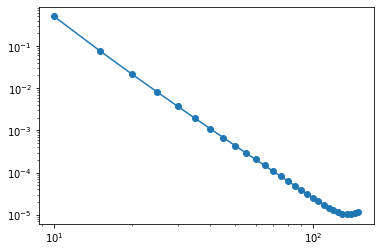

In [2]:
plt.plot(n_grids, errors, marker="o")
plt.xscale('log')
plt.yscale('log')

In [13]:
n_grids = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]


In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt

errors = []
for n_grid in n_grids:
    loss = torch.load('./poisson_results/loss_n_{}'.format(n_grid))
    errors.append(loss.detach().numpy())

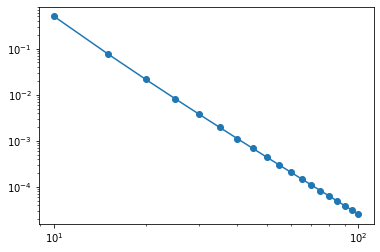

In [15]:
plt.plot(n_grids,errors,marker="o")
plt.xscale('log')
plt.yscale('log')

In [21]:
start_id = 
end_id = -1
(np.log(errors[end_id])-np.log(errors[start_id]))/(np.log(n_grids[end_id]-1)-np.log(n_grids[start_id]-1))

-4.033332403447545